# Project Storm: SCS Wind Occurrence Prediction Model (Florida)

This notebook trains a model to predict the monthly probability of Severe Convective Storm (SCS) wind event occurrence in **Florida counties** based on processed climate variables.

**Data Requirements:**
1.  `county_monthly_climate_variables_12.csv` (or `.parquet`): Output from the state-filtered `process_climate_data_target.py` script. Should contain the 8 climate variables for FL counties.
2.  `county_events.csv`: Original full event list, filtered for FL counties and `event_type == 'scs_wind'`.
3.  County Definitions (Optional, for context): `data/counties/2024_counties.txt`

**Target:** Predict binary occurrence (1 if >=1 `scs_wind` event occurred in county-month, 0 otherwise).

In [1]:
# --- Cell 2: Code (Setup & Configuration) ---

import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
# from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb # Or import xgboost
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, auc, ConfusionMatrixDisplay
# from imblearn.over_sampling import SMOTE # Optional
import matplotlib.pyplot as plt
import logging
import datetime # Import datetime to potentially get current year
import geopandas as gpd # Needed for getting GEOIDs from shapefile

# --- Configuration ---
# --- Input Data Paths ---
# Use the target states file
CLIMATE_FILE = "../output/processed_climate/county_monthly_climate_variables_target_states.parquet"
# Or: CLIMATE_FILE = "../output/processed_climate/county_monthly_climate_variables_target_states.csv"
EVENTS_FILE = "../output/final/county_events.csv"
COUNTIES_DEF_FILE = "../data/counties/2024_counties.txt"
COUNTY_SHAPEFILE_PATH = "../data/geospatial/tl_2024_us_county.shp"

# --- Model & Target Setup ---
TARGET_EVENT_TYPE = 'scs_wind' # <-- CHANGED to SCS Wind
# TARGET_STATE_FIPS = '12'      # Florida's state FIPS code  <- REMOVED
# TARGET_STATE_ABBR = 'FL'      # <<< --- REMOVED ---
target_state_fips = [
    "12", # FL
    "20", # KS
    "29", # MO
    "40", # OK
    "48", # TX
    "05", # AR
    "22", # LA
    "28", # MS
    "01", # AL
    "13", # GA
    "45", # SC
    "37", # NC
    "47", # TN
    "51"  # VA
]


# --- Feature Engineering Parameters ---
LAG_MONTHS = [1, 3, 6] # Define which lags to create for climate vars

# --- Train/Test Split Parameters ---
TRAIN_YEAR_END = 2021     # Train on data up to (and including) this year
TEST_YEAR_START = 2022    # Test on data starting from this year
MAX_EVALUATION_YEAR = 2024 # Last year with actual event data

# --- Output Paths ---
MODEL_OUTPUT_DIR = "../output/models"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
# Update output filenames
SCALER_PATH = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_states_scaler.joblib")
MODEL_PATH = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_states_lgbm_model.joblib")

# --- Other Parameters ---
RANDOM_STATE = 42

# --- Setup Logger ---
LOG_FILE = "../logs/model_training_SCS_TargetStates_log.log" # <-- CHANGED Log file name
logger = logging.getLogger("ModelTrainingLoggerSCS_TargetStates") # <-- CHANGED Logger name
logger.setLevel(logging.DEBUG)
if not logger.handlers:
    fh = logging.FileHandler(LOG_FILE, mode='w'); fh.setLevel(logging.DEBUG)
    fh_formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"); fh.setFormatter(fh_formatter); logger.addHandler(fh)
    sh = logging.StreamHandler(); sh.setLevel(logging.INFO)
    sh_formatter = logging.Formatter("[%(asctime)s] [%(levelname)s] %(name)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S"); sh.setFormatter(sh_formatter); logger.addHandler(sh)

logger.info(f"--- Model Training Notebook Started (Target States {TARGET_EVENT_TYPE}) ---") # <-- CHANGED Log message
logger.info(f"Configuration:")
logger.info(f"  Climate Data File: {CLIMATE_FILE}")
logger.info(f"  Events Data File: {EVENTS_FILE}")
logger.info(f"  Target Event: {TARGET_EVENT_TYPE}")
# logger.info(f"  Target State FIPS: {TARGET_STATE_FIPS}") # <-- REMOVED
logger.info(f"  Target State FIPS List: {target_state_fips}") # ADDED
logger.info(f"  Lag Months: {LAG_MONTHS}")
logger.info(f"  Train Year End: {TRAIN_YEAR_END}")
logger.info(f"  Test Year Start: {TEST_YEAR_START}")
logger.info(f"  Max Evaluation Year: {MAX_EVALUATION_YEAR}")


# --- Get Target State County GEOIDs ---
# (This section modified to get GEOIDs for all target states)
target_geoids = [] # Renamed from target_geoids
try:
    # Use STATEFP from the shapefile or the counties definition file
    # Let's try the counties definition file first as it's smaller
    try:
        df_county_defs = pd.read_csv(COUNTIES_DEF_FILE, delimiter='\t', dtype={'GEOID': str, 'STATEFP': str}) # Ensure STATEFP is str
        df_county_defs.columns = df_county_defs.columns.str.strip()
        statefp_col = 'STATEFP'
        if 'STATEFP' not in df_county_defs.columns:
             # Try USPS if STATEFP is missing in txt file
             if 'USPS' in df_county_defs.columns:
                 logger.warning(f"STATEFP not in {COUNTIES_DEF_FILE}. Attempting lookup via USPS (less reliable for FIPS match).")
                 # Need a mapping from FIPS to USPS abbreviation
                 fips_to_usps = {
                     "12": "FL", "20": "KS", "29": "MO", "40": "OK", "48": "TX",
                     "05": "AR", "22": "LA", "28": "MS", "01": "AL", "13": "GA",
                     "45": "SC", "37": "NC", "47": "TN", "51": "VA"
                 }
                 target_usps_list = [fips_to_usps[fips] for fips in target_state_fips if fips in fips_to_usps]
                 target_geoids = df_county_defs[df_county_defs['USPS'].isin(target_usps_list)]['GEOID'].astype(str).str.strip().str.zfill(5).unique().tolist()
                 if target_geoids:
                     logger.info(f"Found {len(target_geoids)} GEOIDs using USPS codes from {COUNTIES_DEF_FILE}.")
                 else:
                     raise ValueError("Could not find GEOIDs using USPS codes either.")
             else:
                 raise ValueError(f"Neither STATEFP nor USPS column found in {COUNTIES_DEF_FILE}.")
        else: # Found STATEFP in txt file
            df_county_defs[statefp_col] = df_county_defs[statefp_col].astype(str).str.strip() # Ensure clean FIPS
            target_geoids = df_county_defs[df_county_defs[statefp_col].isin(target_state_fips)]['GEOID'].astype(str).str.strip().str.zfill(5).unique().tolist()
            logger.info(f"Found {len(target_geoids)} GEOIDs using STATEFP from {COUNTIES_DEF_FILE}.")

    except (FileNotFoundError, ValueError) as txt_err:
        logger.warning(f"Could not get GEOIDs from {COUNTIES_DEF_FILE} ({txt_err}). Trying shapefile {COUNTY_SHAPEFILE_PATH}")
        gdf_counties = gpd.read_file(COUNTY_SHAPEFILE_PATH, dtype={'GEOID': str, 'STATEFP': str})
        if 'STATEFP' not in gdf_counties.columns:
             raise ValueError(f"STATEFP column not found in shapefile {COUNTY_SHAPEFILE_PATH} either.")
        statefp_col = 'STATEFP'
        gdf_counties[statefp_col] = gdf_counties[statefp_col].astype(str).str.strip()
        target_geoids = gdf_counties[gdf_counties[statefp_col].isin(target_state_fips)]['GEOID'].astype(str).str.strip().str.zfill(5).unique().tolist()
        logger.info(f"Found {len(target_geoids)} GEOIDs using STATEFP from shapefile {COUNTY_SHAPEFILE_PATH}.")


    if not target_geoids:
        raise ValueError(f"No GEOIDs found for target states FIPS: {target_state_fips}")
    logger.info(f"Identified {len(target_geoids)} target state county GEOIDs.")
except Exception as e:
    logger.exception(f"Failed to load target state county GEOIDs: {e}"); raise

# --- Define TARGET_VARIABLES dictionary (Reflects input climate data columns) ---
TARGET_VARIABLES = { # Should match variables in CLIMATE_FILE
    'tasmax': 'Max Temp', 'huss': 'Spec Humid', 'hfss': 'Sens Heat Flux',
    'pr': 'Precip', 'psl': 'Sea Level Press', 'mrsos': 'Soil Moisture',
    'orog': 'Altitude', 'sfcWind': 'Wind Speed'
}
logger.debug(f"TARGET_VARIABLES used (from climate file): {list(TARGET_VARIABLES.values())}")


[2025-04-11 10:55:40] [INFO] ModelTrainingLoggerSCS_TargetStates - --- Model Training Notebook Started (Target States scs_wind) ---
[2025-04-11 10:55:40] [INFO] ModelTrainingLoggerSCS_TargetStates - Configuration:
[2025-04-11 10:55:40] [INFO] ModelTrainingLoggerSCS_TargetStates -   Climate Data File: ../output/processed_climate/county_monthly_climate_variables_target_states.parquet
[2025-04-11 10:55:40] [INFO] ModelTrainingLoggerSCS_TargetStates -   Events Data File: ../output/final/county_events.csv
[2025-04-11 10:55:40] [INFO] ModelTrainingLoggerSCS_TargetStates -   Target Event: scs_wind
[2025-04-11 10:55:40] [INFO] ModelTrainingLoggerSCS_TargetStates -   Target State FIPS List: ['12', '20', '29', '40', '48', '05', '22', '28', '01', '13', '45', '37', '47', '51']
[2025-04-11 10:55:40] [INFO] ModelTrainingLoggerSCS_TargetStates -   Lag Months: [1, 3, 6]
[2025-04-11 10:55:40] [INFO] ModelTrainingLoggerSCS_TargetStates -   Train Year End: 2021
[2025-04-11 10:55:40] [INFO] ModelTrainingL

In [2]:
# --- Cell 3: Load Data ---
logger.info("Loading processed climate (FL only) and full event data...")
if not target_geoids:
    logger.error("Florida GEOID list is empty. Cannot proceed.")
    raise ValueError("Florida GEOID list empty.")

try:
    # Load the climate data already processed for Florida
    if CLIMATE_FILE.endswith(".parquet"):
        df_climate_target = pd.read_parquet(CLIMATE_FILE)
    else:
        df_climate_target = pd.read_csv(CLIMATE_FILE, parse_dates=['time'])
    # Ensure geoid is string and matches expected format
    df_climate_target['county_geoid'] = df_climate_target['county_geoid'].astype(str).str.strip().str.zfill(5)
    # Filter climate data just to be sure it only contains FL geoids (in case source file had others)
    df_climate_target = df_climate_target[df_climate_target['county_geoid'].isin(target_geoids)].copy()
    logger.info(f"Loaded and filtered Florida climate data shape: {df_climate_target.shape}")
    if df_climate_target.empty: raise ValueError("Climate data is empty after filtering for Florida GEOIDs.")

    # Load full events file
    df_events = pd.read_csv(EVENTS_FILE, parse_dates=['first_impact_dt'], dtype={'county_geoid': str})
    df_events['county_geoid'] = df_events['county_geoid'].astype(str).str.strip().str.zfill(5) # Ensure consistent padding
    logger.info(f"Loaded full events data shape: {df_events.shape}")

except FileNotFoundError as fe:
     logger.exception(f"Input file not found: {fe}")
     raise fe
except Exception as e:
    logger.exception(f"Failed to load data: {e}")
    raise e

[2025-04-11 10:55:40] [INFO] ModelTrainingLoggerSCS_TargetStates - Loading processed climate (FL only) and full event data...
[2025-04-11 10:55:40] [INFO] ModelTrainingLoggerSCS_TargetStates - Loaded and filtered Florida climate data shape: (362628, 10)
C:\Users\60864\AppData\Local\Temp\ipykernel_29260\3276494015.py:21: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_events = pd.read_csv(EVENTS_FILE, parse_dates=['first_impact_dt'], dtype={'county_geoid': str})
[2025-04-11 10:55:41] [INFO] ModelTrainingLoggerSCS_TargetStates - Loaded full events data shape: (226538, 4)


In [3]:
# --- NEW Cell 3.5: Load and Preprocess Climate Indices (WITH DETAILED LOGGING & ROBUST PARSING) ---

logger.info("--- Loading and Preprocessing Climate Indices ---")

# --- URLs for NOAA PSL Index Data ---
AMO_URL = "https://psl.noaa.gov/data/correlation/amon.us.data" # Unsmoothed AMO from ERSSTv5
TNA_URL = "https://psl.noaa.gov/data/correlation/tna.data"     # Tropical North Atlantic SST Anomaly from ERSSTv5
NINO34_URL = "https://psl.noaa.gov/data/correlation/nina34.data" # Nino 3.4 Index from ERSSTv5

# --- Function to load and process index data (MORE ROBUST PARSING + LOGGING) ---
# --- Function to load and process index data (ADDED RAW PRINT) ---
import requests # Need requests to fetch content easily

# --- Function to load and process index data (ADDED verify=False) ---
import requests # Ensure requests is imported

# --- Function to load and process index data (Corrected Parser for NOAA PSL format) ---
import requests
from io import StringIO # To read text directly

def load_psl_index(url, missing_val=-99.99, date_col_name='time'):
    """
    Loads and parses space-delimited text index files from NOAA PSL.
    Specifically handles format like:
    Line 1: Meta Info (skipped)
    Line 2+: YEAR VAL1 VAL2 ... VAL12 (No header row)
    """
    logger.info(f"Attempting load from: {url}")
    df_final = pd.DataFrame(columns=[date_col_name, 'Index_Value'])
    df_final[date_col_name] = pd.to_datetime(df_final[date_col_name])

    try:
        # --- Fetch content first ---
        logger.debug(f"Fetching raw content (SSL Verification Disabled) for: {os.path.basename(url)}")
        response = requests.get(url, verify=False) # Keep verify=False for SSL skip
        response.raise_for_status()
        logger.debug(f"Content fetched successfully.")

        # --- Use StringIO to read fetched text with pandas ---
        data_io = StringIO(response.text)

        # --- Correct read_csv parameters ---
        col_names = ['Year_Str'] + list(range(1, 13)) # Names: Year_Str, 1, 2, ..., 12

        df_index = pd.read_csv(
            data_io,
            sep=r'\s+',       # Handles one or more spaces
            skiprows=1,       # Skip the first line (e.g., "1948 2023")
            header=None,      # IMPORTANT: No header row in the data lines
            names=col_names,  # Provide names manually
            na_values=[str(missing_val), missing_val, '-999', '-999.0', '-99.99'] # Handle common missing codes
        )
        logger.debug(f"Read {len(df_index)} lines using manual names. Columns: {df_index.columns.tolist()}")

        # --- Data Cleaning & Validation ---
        # Convert Year column to numeric
        df_index['Year'] = pd.to_numeric(df_index['Year_Str'], errors='coerce')
        rows_before_drop = len(df_index); df_index.dropna(subset=['Year'], inplace=True); rows_after_drop = len(df_index)
        if rows_before_drop != rows_after_drop: logger.warning(f"Dropped {rows_before_drop - rows_after_drop} rows with non-numeric Year.")
        if df_index.empty: raise ValueError("No valid Year rows found.")
        df_index['Year'] = df_index['Year'].astype(int)
        logger.debug(f"Shape after Year cleaning: {df_index.shape}")

        # Melt to long format - use numeric month columns now
        id_vars = ['Year']
        value_vars = list(range(1, 13)) # Use the numeric column names 1 through 12
        df_long = df_index.melt(id_vars=id_vars, value_vars=value_vars, var_name='Month', value_name='Index_Value') # Month is already numeric

        # Ensure Month is integer
        df_long['Month'] = pd.to_numeric(df_long['Month'], errors='coerce')
        df_long.dropna(subset=['Month'], inplace=True);
        df_long['Month'] = df_long['Month'].astype(int)

        # Convert Index Value to numeric
        df_long['Index_Value'] = pd.to_numeric(df_long['Index_Value'], errors='coerce')
        rows_before_val_drop = len(df_long); df_long.dropna(subset=['Index_Value'], inplace=True); rows_after_val_drop = len(df_long)
        if rows_before_val_drop != rows_after_val_drop: logger.debug(f"Dropped {rows_before_val_drop - rows_after_val_drop} rows with missing Index_Value.")
        if df_long.empty: raise ValueError("No valid numeric Index_Value data found.")
        logger.debug(f"Shape after value cleaning: {df_long.shape}")

        # Create datetime
        date_str = df_long['Year'].astype(str) + '-' + df_long['Month'].astype(str).str.zfill(2) + '-01'
        df_long['time'] = pd.to_datetime(date_str, format='%Y-%m-%d')

        # Select and rename
        df_final = df_long[['time', 'Index_Value']].sort_values('time').reset_index(drop=True)
        logger.info(f"Successfully processed index: {os.path.basename(url)}. Final Shape: {df_final.shape}")

    except requests.exceptions.RequestException as req_e:
         logger.exception(f"HTTP Request failed for {url}: {req_e}")
    except Exception as e:
        logger.exception(f"Failed to load or process index from {url}: {e}")
        # Return empty DataFrame on failure
        df_final = pd.DataFrame(columns=[date_col_name, 'Index_Value'])
        df_final[date_col_name] = pd.to_datetime(df_final[date_col_name])

    return df_final

# --- The rest of Cell 3.5 (calling load_psl_index, calculating averages, merging) remains the same ---
# ... calls to load_psl_index ...
# ... calculate averages ...
# ... merge indices ...
# ... final check and display ...

# --- The rest of Cell 3.5 (calling load_psl_index, calculating averages, merging) remains the same ---
# ... calls to load_psl_index ...
# ... calculate averages ...
# ... merge indices ...
# ... final check and display ...

# --- The rest of Cell 3.5 (calling load_psl_index, calculating averages, merging) remains the same ---
# ... calls to load_psl_index ...
# ... calculate averages ...
# ... merge indices ...
# ... final check and display ...

# --- Load Indices ---
logger.info("Calling load_psl_index for AMO, TNA, Nino34...")
df_amo_monthly = load_psl_index(AMO_URL)
logger.info(f"-> AMO Monthly Loaded Shape: {df_amo_monthly.shape}")
df_tna_monthly = load_psl_index(TNA_URL)
logger.info(f"-> TNA Monthly Loaded Shape: {df_tna_monthly.shape}")
df_nino34_monthly = load_psl_index(NINO34_URL)
logger.info(f"-> Nino34 Monthly Loaded Shape: {df_nino34_monthly.shape}")

# Check if any loading failed critically before proceeding
if df_amo_monthly.empty or df_tna_monthly.empty or df_nino34_monthly.empty:
     logger.error("One or more climate indices failed to load. Cannot proceed with merging/calculations.")
     # Create empty df_indices to prevent NameError later but signal failure
     df_indices = pd.DataFrame(columns=['year','TNA_ASO','Nino34_ASO','AMO_Annual'])
else:
    # --- Calculate Relevant Averages ---
    logger.info("Calculating index averages...")
    # AMO Annual Average
    df_amo_annual = pd.DataFrame(columns=['year', 'AMO_Annual']) # Initialize
    try:
        df_amo_temp = df_amo_monthly.set_index('time')
        df_amo_annual = df_amo_temp.resample('AS-JAN')['Index_Value'].mean().reset_index() # Annual average, starting Jan
        df_amo_annual.rename(columns={'Index_Value': 'AMO_Annual'}, inplace=True)
        df_amo_annual['year'] = df_amo_annual['time'].dt.year
        logger.info(f"  -> Calculated AMO Annual Shape: {df_amo_annual.shape}")
    except Exception as e:
         logger.exception(f"Could not calculate annual AMO average: {e}")


    # ASO Average Function
    def calculate_aso_avg(df, col_name):
        df_aso_avg = pd.DataFrame(columns=['year', col_name]) # Initialize
        if df.empty: return df_aso_avg
        try:
            df_copy = df.copy()
            df_copy['year'] = df_copy['time'].dt.year
            df_copy['month'] = df_copy['time'].dt.month
            df_aso = df_copy[df_copy['month'].isin([8, 9, 10])]
            if df_aso.empty: logger.warning(f"No Aug-Oct data found for {col_name}"); return df_aso_avg
            df_aso_avg = df_aso.groupby('year')['Index_Value'].mean().reset_index()
            df_aso_avg.rename(columns={'Index_Value': col_name}, inplace=True)
        except Exception as e:
             logger.exception(f"Could not calculate ASO average for {col_name}: {e}")
        return df_aso_avg

    df_tna_aso = calculate_aso_avg(df_tna_monthly, 'TNA_ASO')
    logger.info(f"  -> Calculated TNA ASO avg Shape: {df_tna_aso.shape}")
    df_nino34_aso = calculate_aso_avg(df_nino34_monthly, 'Nino34_ASO')
    logger.info(f"  -> Calculated Nino34 ASO avg Shape: {df_nino34_aso.shape}")

    # Check if averaging failed
    if df_tna_aso.empty or df_nino34_aso.empty or df_amo_annual.empty:
         logger.error("One or more index averaging steps resulted in empty DataFrames.")
         df_indices = pd.DataFrame(columns=['year','TNA_ASO','Nino34_ASO','AMO_Annual']) # Ensure empty df defined
    else:
        # --- Combine Indices for Merging ---
        logger.info("Combining calculated indices...")
        try:
            # Merge ASO indices first
            df_indices = pd.merge(df_tna_aso, df_nino34_aso, on='year', how='outer')
            logger.info(f"  -> Shape after merging TNA+Nino34: {df_indices.shape}")
            # Merge annual AMO index
            df_indices = pd.merge(df_indices, df_amo_annual[['year', 'AMO_Annual']], on='year', how='outer')
            logger.info(f"  -> Shape after merging AMO: {df_indices.shape}")
        except Exception as merge_e:
             logger.exception(f"Failed to merge indices: {merge_e}")
             df_indices = pd.DataFrame(columns=['year','TNA_ASO','Nino34_ASO','AMO_Annual']) # Ensure empty df defined

# Final Check and Display
logger.info(f"Combined climate indices ready for merging. Final Shape: {df_indices.shape}")
if df_indices.empty:
    logger.error("Final combined indices DataFrame is empty!")
else:
    logger.info("Sample of final combined indices:")
    print("\n--- Sample of Processed Climate Indices ---")
    display(df_indices.tail())
    # Log NaN counts in final index df
    final_index_nans = df_indices.isnull().sum()
    if final_index_nans.sum() > 0:
        logger.warning(f"NaNs found in final combined indices:\n{final_index_nans[final_index_nans > 0]}")

[2025-04-11 10:55:41] [INFO] ModelTrainingLoggerSCS_TargetStates - --- Loading and Preprocessing Climate Indices ---
[2025-04-11 10:55:41] [INFO] ModelTrainingLoggerSCS_TargetStates - Calling load_psl_index for AMO, TNA, Nino34...
[2025-04-11 10:55:41] [INFO] ModelTrainingLoggerSCS_TargetStates - Attempting load from: https://psl.noaa.gov/data/correlation/amon.us.data
c:\Users\60864\Desktop\PycharmProjects\storm\env\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'psl.noaa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
[2025-04-11 10:55:42] [WARNING] ModelTrainingLoggerSCS_TargetStates - Dropped 4 rows with non-numeric Year.
[2025-04-11 10:55:42] [INFO] ModelTrainingLoggerSCS_TargetStates - Successfully processed index: amon.us.data. Final Shape: (907, 2)
[2025-04-11 10:55:42] [INFO] ModelTrainingLoggerSCS_T


--- Sample of Processed Climate Indices ---


,year,TNA_ASO,Nino34_ASO,AMO_Annual
72,2020,0.573333,25.870000,0.268167
73,2021,0.420000,26.086667,0.222583
74,2022,0.530000,25.753333,0.246917
75,2023,1.370000,28.320000,-85.678286
76,2024,1.066667,26.540000,NaN


[2025-04-11 10:55:42] [WARNING] ModelTrainingLoggerSCS_TargetStates - NaNs found in final combined indices:
Nino34_ASO    2
AMO_Annual    1
dtype: int64


In [4]:
# --- Cell 4: Prepare Target Variable (Monthly Occurrence for FL SCS Wind) ---
logger.info(f"Preparing target variable: {TARGET_EVENT_TYPE}_occurred for Florida")
target_col = f'{TARGET_EVENT_TYPE}_occurred' # e.g., 'scs_wind_occurred'
try:
    # Filter events for TARGET_EVENT_TYPE ('scs_wind') and Florida counties BEFORE aggregation
    df_events_target_scs = df_events[
        (df_events['event_type'] == TARGET_EVENT_TYPE) &
        (df_events['county_geoid'].isin(target_geoids))
    ].copy()
    logger.info(f"Found {len(df_events_target_scs)} Florida {TARGET_EVENT_TYPE} event records.")

    if df_events_target_scs.empty:
         logger.warning(f"No '{TARGET_EVENT_TYPE}' events found for Florida counties. Target variable will be all zeros.")
         # Create empty occurrence df with correct columns
         df_monthly_occurrence_target = pd.DataFrame(columns=['county_geoid', 'time', target_col])
         # Ensure 'time' column is datetime for merging
         df_monthly_occurrence_target['time'] = pd.to_datetime(df_monthly_occurrence_target['time'])

    else:
        df_events_target_scs['year_month'] = df_events_target_scs['first_impact_dt'].dt.to_period('M')
        df_monthly_counts_target = df_events_target_scs.groupby(
            ['county_geoid', 'year_month']
        ).size().reset_index(name='event_count')

        # Create binary occurrence flag
        df_monthly_occurrence_target = df_monthly_counts_target[['county_geoid', 'year_month']].drop_duplicates()
        df_monthly_occurrence_target[target_col] = 1

        # Convert Period to timestamp (start of month)
        df_monthly_occurrence_target['time'] = df_monthly_occurrence_target['year_month'].dt.to_timestamp().dt.normalize()
        # Ensure 'time' column is datetime dtype for merging
        df_monthly_occurrence_target['time'] = pd.to_datetime(df_monthly_occurrence_target['time'])

    logger.info(f"Created monthly occurrence data for {len(df_monthly_occurrence_target)} FL county-month {TARGET_EVENT_TYPE} instances.")
except Exception as e:
     logger.exception(f"Failed to prepare target variable: {e}")
     raise e

[2025-04-11 10:55:42] [INFO] ModelTrainingLoggerSCS_TargetStates - Preparing target variable: scs_wind_occurred for Florida
[2025-04-11 10:55:42] [INFO] ModelTrainingLoggerSCS_TargetStates - Found 90242 Florida scs_wind event records.
[2025-04-11 10:55:43] [INFO] ModelTrainingLoggerSCS_TargetStates - Created monthly occurrence data for 37962 FL county-month scs_wind instances.


In [5]:
# --- Cell 5: Feature Engineering & Merging (Indices & Anomalies - CORRECTED MERGE) ---
logger.info("Starting feature engineering and merging (Indices & Anomalies)...")
try:
    # --- Input Checks ---
    if 'df_climate_target' not in locals() or df_climate_target.empty: raise ValueError("df_climate_target missing or empty.")
    if 'df_monthly_occurrence_target' not in locals(): raise NameError("Occurrence data missing.")
    if 'target_geoids' not in locals() or not target_geoids: raise ValueError("target_geoids missing.")
    if 'df_indices' not in locals() or df_indices.empty: raise ValueError("Climate indices missing.")
    target_col = f'{TARGET_EVENT_TYPE}_occurred' # Defined in Cell 2/4
    # --- End Checks ---

    df_climate_target['time'] = pd.to_datetime(df_climate_target['time'])
    # Add year/month cols needed for joining indices and calculating anomalies
    df_climate_target['year'] = df_climate_target['time'].dt.year
    df_climate_target['month'] = df_climate_target['time'].dt.month

    # --- Identify Variable Types ---
    fixed_var_names = ['Altitude']
    known_non_climate_cols = ['county_geoid', 'time', 'year', 'month'] # year/month now exist here
    all_climate_cols = [col for col in df_climate_target.columns if col not in known_non_climate_cols]
    time_varying_climate_vars = [col for col in all_climate_cols if col not in fixed_var_names]
    fixed_climate_vars = [col for col in all_climate_cols if col in fixed_var_names]
    logger.info(f"Identified Time-Varying Vars: {time_varying_climate_vars}")
    logger.info(f"Identified Fixed Vars: {fixed_climate_vars}")

    # --- Calculate Climatology & Anomalies ---
    logger.info("Calculating monthly climatology and anomalies per county...")
    anomaly_cols = []
    climatology_cols = []
    # Calculate for all climate vars (time-varying and fixed) first
    for var in time_varying_climate_vars + fixed_climate_vars:
        clim_col = f'{var}_clim'
        anom_col = f'{var}_anom'
        climatology_cols.append(clim_col) # Keep track of climatology columns
        # Calculate long-term mean for each county and month
        # Ensure calculation happens on the original df_climate_target before potential merges change it
        df_climate_target[clim_col] = df_climate_target.groupby(['county_geoid', 'month'])[var].transform('mean')
        df_climate_target[anom_col] = df_climate_target[var] - df_climate_target[clim_col]
        anomaly_cols.append(anom_col) # Keep all anomalies
        logger.debug(f"Calculated anomaly for {var}")
    logger.info("Anomaly calculation complete.")

    # --- Create base DataFrame for Merging ---
    # Use the actual unique county/time pairs present in the climate data as the base
    # This avoids creating index combinations that don't exist in the climate file
    df_merged_target = df_climate_target[['county_geoid', 'time', 'year', 'month']].copy().drop_duplicates()
    logger.debug(f"Created base index from climate data. Shape: {df_merged_target.shape}")

    # --- Merge Climate Data (including Clim & Anom cols) ---
    # Merge on the keys that define the base index
    df_merged_target = pd.merge(df_merged_target, df_climate_target, on=['county_geoid', 'time', 'year', 'month'], how='left')
    logger.debug(f"Shape after merging climate data back: {df_merged_target.shape}")

    # --- Merge Climate Indices (on year) ---
    df_merged_target = pd.merge(df_merged_target, df_indices, on='year', how='left')
    logger.debug(f"Shape after merging indices: {df_merged_target.shape}")
    index_cols = [col for col in df_indices.columns if col != 'year'] # Get index col names
    index_nan_counts = df_merged_target[index_cols].isnull().sum()
    if index_nan_counts.sum() > 0: logger.warning(f"NaNs found in merged indices:\n{index_nan_counts[index_nan_counts > 0]}")

    # --- Merge Event Occurrence Data (on county_geoid, time) ---
    if not df_monthly_occurrence_target.empty:
         # Ensure time column in occurrence data is datetime64[ns] for merging
         df_monthly_occurrence_target['time'] = pd.to_datetime(df_monthly_occurrence_target['time'])
         df_merged_target = pd.merge(df_merged_target, df_monthly_occurrence_target[['county_geoid', 'time', target_col]], on=['county_geoid', 'time'], how='left')
         df_merged_target[target_col].fillna(0, inplace=True)
    else: df_merged_target[target_col] = 0 # Assign 0 if no occurrence data existed
    df_merged_target[target_col] = df_merged_target[target_col].astype(int)
    logger.debug(f"Shape after merging occurrence: {df_merged_target.shape}")


    # --- Impute Missing Values ---
    # Select columns for imputation: anomalies, indices, fixed vars
    # Exclude original climate values and climatology columns if using anomalies as primary features
    impute_cols = anomaly_cols + index_cols + fixed_climate_vars
    # Ensure columns actually exist before imputation
    impute_cols = [col for col in impute_cols if col in df_merged_target.columns]
    logger.info(f"Imputing NaNs in features: {impute_cols} using ffill/bfill per county/globally.")
    df_merged_target.sort_values(by=['county_geoid', 'time'], inplace=True)
    # Impute time-varying anomalies per county
    anom_impute_cols = [col for col in anomaly_cols if col in df_merged_target.columns]
    if anom_impute_cols:
        df_merged_target[anom_impute_cols] = df_merged_target.groupby('county_geoid')[anom_impute_cols].ffill().bfill()
    # Impute indices globally (since they don't vary by county)
    index_impute_cols = [col for col in index_cols if col in df_merged_target.columns]
    if index_impute_cols:
        df_merged_target[index_impute_cols] = df_merged_target[index_impute_cols].ffill().bfill()
    # Impute fixed variables (shouldn't have NaNs if processed correctly, but check)
    fixed_impute_cols = [col for col in fixed_climate_vars if col in df_merged_target.columns]
    if fixed_impute_cols:
        for fixed_var in fixed_impute_cols:
            if df_merged_target[fixed_var].isnull().any():
                 median_val = df_merged_target[fixed_var].median(); logger.warning(f"NaNs found in fixed var '{fixed_var}'. Imputing with median ({median_val:.2f})."); df_merged_target[fixed_var].fillna(median_val, inplace=True)

    # Check remaining NaNs and drop rows if any exist in the columns used for imputation
    remaining_nans = df_merged_target[impute_cols].isnull().sum()
    if remaining_nans.sum() > 0:
         logger.warning(f"NaNs remaining after imputation:\n{remaining_nans[remaining_nans > 0]}")
         logger.warning("Dropping rows with any remaining NaNs in imputed feature columns.")
         df_merged_target.dropna(subset=impute_cols, inplace=True)


    # --- Create Lagged Features for ANOMALIES of time-varying variables ---
    logger.info(f"Creating lagged features for months: {LAG_MONTHS} (Time-Varying Anomalies only)")
    lag_cols = []
    # Identify time-varying anomaly columns correctly
    time_varying_anom_cols = [f'{var}_anom' for var in time_varying_climate_vars if f'{var}_anom' in df_merged_target.columns]
    if time_varying_anom_cols:
        for lag in LAG_MONTHS:
            for anom_var in time_varying_anom_cols:
                lag_col_name = f'{anom_var}_lag{lag}'
                df_merged_target[lag_col_name] = df_merged_target.groupby('county_geoid')[anom_var].shift(lag)
                lag_cols.append(lag_col_name)
    else: logger.warning("No time-varying anomaly variables found to create lags for.")


    # Create Time Features (Month sin/cos)
    df_merged_target['month_sin'] = np.sin(2 * np.pi * df_merged_target['month']/12)
    df_merged_target['month_cos'] = np.cos(2 * np.pi * df_merged_target['month']/12)

    # Drop rows with NaNs introduced by lagging
    logger.info(f"Dropping rows with NaNs created by lagging.")
    lag_cols_exist = [col for col in lag_cols if col in df_merged_target.columns]
    if lag_cols_exist: df_merged_target.dropna(subset=lag_cols_exist, inplace=True)
    logger.info(f"Shape after dropping lag NaNs: {df_merged_target.shape}")
    if df_merged_target.empty: raise ValueError("DataFrame empty after dropping lag NaNs.")

    # --- Define FINAL Features (X) and Target (y) ---
    # Using: Anomalies + Lags of Anomalies + Indices + Fixed Vars + Time Features
    # Make sure the anomaly columns used here exist
    anomaly_cols_exist = [col for col in anomaly_cols if col in df_merged_target.columns]
    fixed_climate_vars_exist = [col for col in fixed_climate_vars if col in df_merged_target.columns]
    index_cols_exist = [col for col in index_cols if col in df_merged_target.columns]

    feature_cols = (
        anomaly_cols_exist +         # Anomalies of original climate vars
        lag_cols_exist +             # Lags of time-varying anomalies
        index_cols_exist +           # Climate indices (TNA, Nino34, AMO)
        fixed_climate_vars_exist +   # Fixed vars (Altitude)
        ['month_sin', 'month_cos']   # Time features
    )
    # Ensure all selected feature columns exist and remove duplicates
    feature_cols = sorted(list(set([col for col in feature_cols if col in df_merged_target.columns])))

    X = df_merged_target[feature_cols]
    y = df_merged_target[target_col]
    logger.info(f"Prepared final X ({X.shape}) and y ({y.shape}) for Florida {TARGET_EVENT_TYPE}")
    logger.debug(f"Final feature columns ({len(feature_cols)}): {X.columns.tolist()}")

except Exception as e:
    logger.exception(f"Failed during feature engineering/merging: {e}")
    raise e

[2025-04-11 10:55:43] [INFO] ModelTrainingLoggerSCS_TargetStates - Starting feature engineering and merging (Indices & Anomalies)...
[2025-04-11 10:55:43] [INFO] ModelTrainingLoggerSCS_TargetStates - Identified Time-Varying Vars: ['Max Temp', 'Spec Humid', 'Sens Heat Flux', 'Precip', 'Sea Level Press', 'Soil Moisture', 'Wind Speed']
[2025-04-11 10:55:43] [INFO] ModelTrainingLoggerSCS_TargetStates - Identified Fixed Vars: ['Altitude']
[2025-04-11 10:55:43] [INFO] ModelTrainingLoggerSCS_TargetStates - Calculating monthly climatology and anomalies per county...
[2025-04-11 10:55:43] [INFO] ModelTrainingLoggerSCS_TargetStates - Anomaly calculation complete.
[2025-04-11 10:55:43] [WARNING] ModelTrainingLoggerSCS_TargetStates - NaNs found in merged indices:
TNA_ASO       189948
Nino34_ASO    189948
AMO_Annual    207216
dtype: int64
C:\Users\60864\AppData\Local\Temp\ipykernel_29260\996020206.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained a

In [6]:
# --- Cell 6: Split Data (Temporal Split - HISTORICAL ONLY) ---

# --- Determine Data Range ---
try:
    if 'df_merged_target' not in locals() or df_merged_target.empty: raise ValueError("'df_merged_target' missing or empty.")
    if 'year' not in df_merged_target.columns: raise ValueError("'year' column missing.")
    min_data_year = int(df_merged_target['year'].min()) # Ensure int
    max_data_year = int(df_merged_target['year'].max()) # Ensure int
    logger.info(f"Available data range in merged df: {min_data_year} to {max_data_year}")
except Exception as e: logger.exception(f"Error determining data range: {e}"); raise e

# --- Validate Configured Split Years against Data Range ---
if TRAIN_YEAR_END < min_data_year: raise ValueError(f"TRAIN_YEAR_END < min data year.")
if TEST_YEAR_START > MAX_EVALUATION_YEAR: raise ValueError(f"TEST_YEAR_START > MAX_EVALUATION_YEAR.")
if TRAIN_YEAR_END >= TEST_YEAR_START: raise ValueError(f"TRAIN_YEAR_END must be < TEST_YEAR_START.")

actual_max_test_year = min(max_data_year, MAX_EVALUATION_YEAR)
logger.info(f"Train period: <= {TRAIN_YEAR_END}"); logger.info(f"Test period: {TEST_YEAR_START} to {actual_max_test_year}")

try:
    if 'X' not in locals() or 'y' not in locals(): raise NameError("X or y not defined.")
    if X.empty or y.empty: raise ValueError("X or y is empty.")

    train_mask = df_merged_target['year'] <= TRAIN_YEAR_END
    test_mask = (df_merged_target['year'] >= TEST_YEAR_START) & (df_merged_target['year'] <= actual_max_test_year)

    X_train = X[train_mask]; y_train = y[train_mask]

    if not test_mask.any():
         logger.warning(f"No test data found for {TEST_YEAR_START}-{actual_max_test_year}."); X_test = pd.DataFrame(columns=X.columns); y_test = pd.Series(dtype=y.dtype, name=y.name); test_identifiers = pd.DataFrame(columns=['county_geoid', 'time']); test_event_rate_str = "N/A (empty)"
    else:
         X_test = X[test_mask]; y_test = y[test_mask]; test_identifiers = df_merged_target.loc[test_mask, ['county_geoid', 'time']]; test_event_rate = y_test.mean(); test_event_rate_str = f"{test_event_rate:.4f}" if not pd.isna(test_event_rate) else "N/A"

    if not train_mask.any(): raise ValueError("No training data selected.");
    if y_train.nunique() < 2: logger.warning("Training data has only one class!")

    train_event_rate = y_train.mean()
    logger.info(f"Train set shape: {X_train.shape}, Year range: {min_data_year}-{TRAIN_YEAR_END}, Event rate: {train_event_rate:.4f}")
    logger.info(f"Test set shape: {X_test.shape}, Year range: {TEST_YEAR_START}-{actual_max_test_year}, Event rate: {test_event_rate_str}")

    if train_event_rate < 0.01 or train_event_rate > 0.99: logger.warning(f"Significant class imbalance (rate: {train_event_rate:.4f}).")

    # Store Future Climate Data
    future_mask = df_merged_target['year'] > actual_max_test_year
    if future_mask.any():
        X_future = X[future_mask]; future_identifiers = df_merged_target.loc[future_mask, ['county_geoid', 'time']]; future_min_year, future_max_year = df_merged_target.loc[future_mask, 'year'].min(), df_merged_target.loc[future_mask, 'year'].max()
        logger.info(f"Separated future climate data ({len(X_future)} rows, years {future_min_year}-{future_max_year}).")
    else: logger.info(f"No future climate data found > {actual_max_test_year}."); X_future = pd.DataFrame(columns=X.columns)

except Exception as e: logger.exception(f"Error during data splitting: {e}"); raise e

[2025-04-11 10:55:44] [INFO] ModelTrainingLoggerSCS_TargetStates - Available data range in merged df: 2015 to 2035
[2025-04-11 10:55:44] [INFO] ModelTrainingLoggerSCS_TargetStates - Train period: <= 2021
[2025-04-11 10:55:45] [INFO] ModelTrainingLoggerSCS_TargetStates - Test period: 2022 to 2024
[2025-04-11 10:55:45] [INFO] ModelTrainingLoggerSCS_TargetStates - Train set shape: (112242, 35), Year range: 2015-2021, Event rate: 0.1954
[2025-04-11 10:55:45] [INFO] ModelTrainingLoggerSCS_TargetStates - Test set shape: (51804, 35), Year range: 2022-2024, Event rate: 0.2098
[2025-04-11 10:55:45] [INFO] ModelTrainingLoggerSCS_TargetStates - Separated future climate data (189948 rows, years 2025-2035).


In [7]:
# --- Cell 7: Scale Features ---
logger.info("Scaling final features using StandardScaler...")
try:
    # --- Input Checks ---
    if 'X_train' not in locals() or 'X_test' not in locals(): raise NameError("X_train/X_test missing.")
    if X_train.empty: raise ValueError("X_train empty.")
    if 'SCALER_PATH' not in locals(): raise NameError("SCALER_PATH variable not defined from Cell #2.")
    # --- End Checks ---

    scaler = StandardScaler()
    # Fit scaler ONLY on training data
    X_train_scaled = scaler.fit_transform(X_train)
    # Transform test data using the SAME fitted scaler
    X_test_scaled = scaler.transform(X_test) if not X_test.empty else np.array([]).reshape(0, X_train.shape[1])

    logger.info("Features scaled.")
    logger.debug(f"X_train_scaled shape: {X_train_scaled.shape}")
    logger.debug(f"X_test_scaled shape: {X_test_scaled.shape}")


    # --- Save the scaler using the correct path from Cell #2 ---
    joblib.dump(scaler, SCALER_PATH) # Use SCALER_PATH defined in config
    logger.info(f"Scaler saved to {SCALER_PATH}")
    # --- End Correction ---

except NameError as ne: logger.exception(f"Missing variable for scaling: {ne}"); raise ne
except ValueError as ve: logger.exception(f"ValueError during scaling: {ve}"); raise ve
except Exception as e: logger.exception(f"Failed during feature scaling: {e}"); raise e

[2025-04-11 10:55:45] [INFO] ModelTrainingLoggerSCS_TargetStates - Scaling final features using StandardScaler...
[2025-04-11 10:55:45] [INFO] ModelTrainingLoggerSCS_TargetStates - Features scaled.
[2025-04-11 10:55:45] [INFO] ModelTrainingLoggerSCS_TargetStates - Scaler saved to ../output/models\scs_wind_target_states_scaler.joblib


In [8]:
# --- Cell 8: Handle Imbalance (Example: using class_weight) ---
try:
    if 'y_train' not in locals(): raise NameError("y_train not defined.")
    train_event_rate = y_train.mean()
    use_class_weight = 'balanced' if (train_event_rate < 0.1 or train_event_rate > 0.9) else None
    logger.info(f"Based on training event rate ({train_event_rate:.4f}), setting class_weight: {use_class_weight}")
except Exception as e: logger.exception(f"Error determining class weight: {e}"); use_class_weight = None

[2025-04-11 10:55:45] [INFO] ModelTrainingLoggerSCS_TargetStates - Based on training event rate (0.1954), setting class_weight: None


In [9]:
# --- Cell 9: Train Model (Calibrated LightGBM for SCS Wind) ---
logger.info(f"Training Calibrated LightGBM model for {TARGET_EVENT_TYPE}...")
calibrated_clf = None # Initialize model variable
try:
    if 'X_train_scaled' not in locals() or 'y_train' not in locals(): raise NameError("Scaled train data missing.")
    if X_train_scaled.shape[0] == 0: raise ValueError("Scaled train data empty.")

    # Define base estimator
    base_lgbm = lgb.LGBMClassifier(
        class_weight=use_class_weight, # Determined in Cell 8
        random_state=RANDOM_STATE,
        n_estimators=200, learning_rate=0.05, num_leaves=31 # Example params - Consider tuning
    )

    # Fit the base estimator first (required for cv='prefit')
    logger.info("Fitting base LightGBM model...")
    base_lgbm.fit(X_train_scaled, y_train)
    logger.info("Base model fitted.")

    # Wrap with CalibratedClassifierCV
    # method='isotonic' is often good for non-linear models like trees, requires sufficient data
    # method='sigmoid' (Platt scaling) assumes ROC is sigmoid shape, often faster
    logger.info("Calibrating probabilities using Isotonic Regression (cv='prefit')...")
    calibrated_clf = CalibratedClassifierCV(
        base_lgbm,
        method='isotonic',
        cv='prefit' # Use the already fitted base estimator
    )
    # The .fit here for CalibratedClassifierCV with cv='prefit' essentially just trains the calibrator
    calibrated_clf.fit(X_train_scaled, y_train)

    logger.info("Calibrated LightGBM training complete.")

    # --- Update Save Path ---
    MODEL_PATH = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_AnomInd_lgbm_calibrated.joblib") # Added AnomInd tag
    # --- End Update ---
    joblib.dump(calibrated_clf, MODEL_PATH)
    logger.info(f"Calibrated model saved to {MODEL_PATH}")

except Exception as e: logger.exception(f"Failed training: {e}"); raise e

[2025-04-11 10:55:45] [INFO] ModelTrainingLoggerSCS_TargetStates - Training Calibrated LightGBM model for scs_wind...
[2025-04-11 10:55:45] [INFO] ModelTrainingLoggerSCS_TargetStates - Fitting base LightGBM model...


[LightGBM] [Info] Number of positive: 21936, number of negative: 90306
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7436
[LightGBM] [Info] Number of data points in the train set: 112242, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195435 -> initscore=-1.415075
[LightGBM] [Info] Start training from score -1.415075


[2025-04-11 10:55:47] [INFO] ModelTrainingLoggerSCS_TargetStates - Base model fitted.
[2025-04-11 10:55:47] [INFO] ModelTrainingLoggerSCS_TargetStates - Calibrating probabilities using Isotonic Regression (cv='prefit')...
c:\Users\60864\Desktop\PycharmProjects\storm\env\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\60864\Desktop\PycharmProjects\storm\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[2025-04-11 10:55:47] [INFO] ModelTrainingLoggerSCS_TargetStates - Calibrated LightGBM training complete.
[2025-04-11 10:55:47] [INFO] ModelTrainingLoggerSCS_TargetStates - Calibrated model saved to ../output/models\scs_wind_target_AnomInd_lgbm_calibrated.joblib


[2025-04-11 10:55:49] [INFO] ModelTrainingLoggerSCS_TargetStates - Evaluating scs_wind occurrence calibrated model on Test Set...
[2025-04-11 10:55:49] [INFO] ModelTrainingLoggerSCS_TargetStates - Evaluating on Test Set...
[2025-04-11 10:55:49] [INFO] ModelTrainingLoggerSCS_TargetStates - 
--- Test Set Evaluation Results (scs_wind Occ - FL) ---
[2025-04-11 10:55:49] [INFO] ModelTrainingLoggerSCS_TargetStates - AUC: 0.7455, AUC-PR: 0.4044
Report:
                   precision    recall  f1-score   support

      No scs_wind       0.82      0.93      0.87     40934
scs_wind Occurred       0.44      0.21      0.28     10870

         accuracy                           0.78     51804
        macro avg       0.63      0.57      0.58     51804
     weighted avg       0.74      0.78      0.75     51804




--- Test Set Evaluation Results (scs_wind Occ - FL) ---
AUC: 0.7455
AUC-PR: 0.4044

Report:
                   precision    recall  f1-score   support

      No scs_wind       0.82      0.93      0.87     40934
scs_wind Occurred       0.44      0.21      0.28     10870

         accuracy                           0.78     51804
        macro avg       0.63      0.57      0.58     51804
     weighted avg       0.74      0.78      0.75     51804



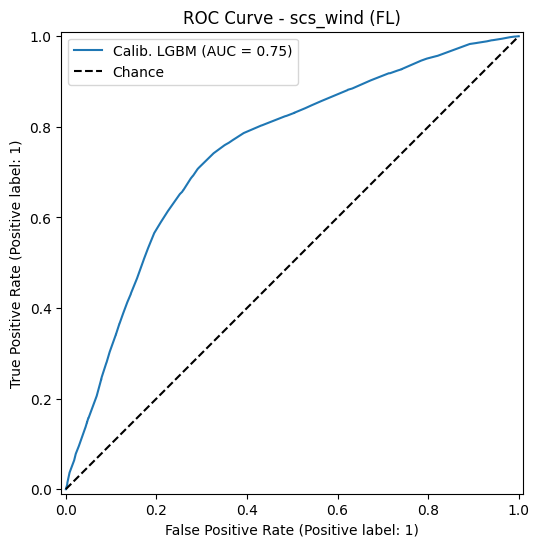

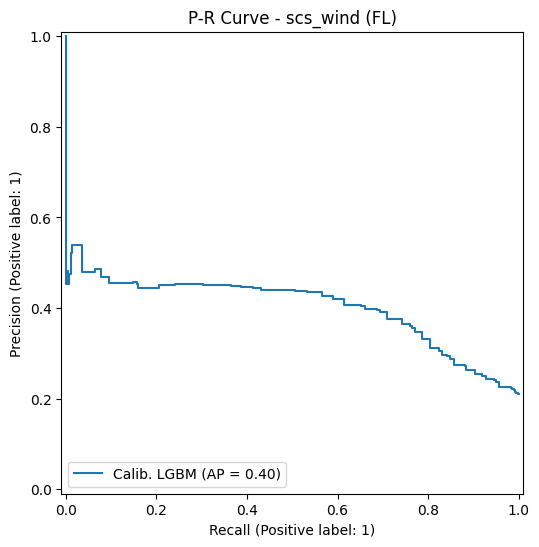

[2025-04-11 10:55:49] [WARNING] ModelTrainingLoggerSCS_TargetStates - Cannot get feature importances.
[2025-04-11 10:55:49] [INFO] ModelTrainingLoggerSCS_TargetStates - Generating predictions for the full historical period (train + test)...
[2025-04-11 10:55:50] [INFO] ModelTrainingLoggerSCS_TargetStates - Combined full historical predictions. Shape: (164046, 4). Time range: 2015-07-01 00:00:00 - 2024-12-01 00:00:00
[2025-04-11 10:55:50] [INFO] ModelTrainingLoggerSCS_TargetStates - Calculated historical monthly expected hits.
[2025-04-11 10:55:50] [INFO] ModelTrainingLoggerSCS_TargetStates - --- Model Evaluation & Historical Prediction Complete ---


In [10]:
# --- Cell 10: Evaluate Model (Classification Metrics & Generate/SAVE Historical Predictions) ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
# Removed statsmodels import as it's not used here
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import os
import warnings

# Define path for saving historical predictions
HIST_PREDS_OUTPUT_DIR = "../output/predictions"
os.makedirs(HIST_PREDS_OUTPUT_DIR, exist_ok=True)
HIST_PREDS_PATH = os.path.join(HIST_PREDS_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_states_historical_preds.parquet") # Save as parquet

logger.info(f"Evaluating {TARGET_EVENT_TYPE} occurrence calibrated model on Test Set...")
df_hist_results_full = pd.DataFrame() # Initialize df to store full historical results

try:
    # --- Load Model & Scaler ---
    # Ensure MODEL_PATH and SCALER_PATH point to the correct EVALUATION model/scaler for this notebook's context
    if 'calibrated_clf' not in locals() and not os.path.exists(MODEL_PATH): raise FileNotFoundError(f"Model file missing: {MODEL_PATH}")
    if 'scaler' not in locals() and not os.path.exists(SCALER_PATH): raise FileNotFoundError(f"Scaler file missing: {SCALER_PATH}")
    model_to_eval = calibrated_clf if 'calibrated_clf' in locals() else joblib.load(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH) if 'scaler' not in locals() else scaler

    # --- Check Train/Test Data ---
    if 'X_train_scaled' not in locals() or 'y_train' not in locals() or 'X_train' not in locals(): raise NameError("Training data missing.")
    if 'X_test_scaled' not in locals() or 'y_test' not in locals() or 'test_identifiers' not in locals(): raise NameError("Test data missing.")
    if 'df_merged_target' not in locals(): raise NameError("df_merged_target missing for train identifiers.") # Use correct name from Cell 5
    if 'train_mask' not in locals(): raise NameError("train_mask missing.")

    # --- Test Set Evaluation (remains same) ---
    if X_test_scaled.shape[0] == 0: logger.warning("Test set empty. Skipping evaluation.")
    else:
        logger.info("Evaluating on Test Set...")
        with warnings.catch_warnings(): # Suppress warnings
            warnings.filterwarnings("ignore", category=UserWarning); y_pred_proba_test = model_to_eval.predict_proba(X_test_scaled)[:, 1]; y_pred_class_test = model_to_eval.predict(X_test_scaled)

        # Calculate & Print/Log Metrics (remains same)
        if y_test.nunique() < 2: logger.warning("Test set single class."); auc_score, pr_auc, report = np.nan, np.nan, "N/A"
        else:
            auc_score = roc_auc_score(y_test, y_pred_proba_test); precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test); pr_auc = auc(recall, precision)
            report = classification_report(y_test, y_pred_class_test, target_names=[f'No {TARGET_EVENT_TYPE}', f'{TARGET_EVENT_TYPE} Occurred'], zero_division=0)
        logger.info(f"\n--- Test Set Eval Results ({TARGET_EVENT_TYPE} Occ - Target States) ---") # Updated geo scope in title
        logger.info(f"AUC: {auc_score:.4f}, AUC-PR: {pr_auc:.4f}\nReport:\n{report}")
        print(f"\n--- Test Set Eval Results ({TARGET_EVENT_TYPE} Occ - Target States) ---"); print(f"AUC: {auc_score:.4f}"); print(f"AUC-PR: {pr_auc:.4f}"); print("\nReport:"); print(report)

        # Plotting (remains same)
        if y_test.nunique() >= 2: #... (Plot ROC, PR Curve, save with target_states names) ...
            roc_filename=os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_AnomInd_calib_roc_curve.png"); pr_filename=os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_AnomInd_calib_pr_curve.png"); fi_filename=os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_AnomInd_calib_feature_importance.png")
            plt.figure(figsize=(8, 6)); RocCurveDisplay.from_predictions(y_test, y_pred_proba_test, name='Calib. LGBM', ax=plt.gca()); plt.plot([0, 1], [0, 1], 'k--'); plt.title(f'ROC Curve - {TARGET_EVENT_TYPE} (Target States)'); plt.legend(); plt.savefig(roc_filename); plt.show()
            plt.figure(figsize=(8, 6)); PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_test, name='Calib. LGBM', ax=plt.gca()); plt.title(f'P-R Curve - {TARGET_EVENT_TYPE} (Target States)'); plt.savefig(pr_filename); plt.show()

        # Feature Importances (remains same)
        if hasattr(model_to_eval, 'base_estimator') and hasattr(model_to_eval.base_estimator, 'feature_importances_'): #... (Feature importance logic) ...
             if 'feature_cols' in locals(): importances = pd.Series(model_to_eval.base_estimator.feature_importances_, index=feature_cols).sort_values(ascending=False); logger.info(f"Top Features:\n{importances.head(20).to_string()}"); print("\nTop 20 Feats:"); print(importances.head(20)); plt.figure(figsize=(10, 8)); importances.head(20).plot(kind='barh'); plt.title(f"Feat Imp ({TARGET_EVENT_TYPE} Occ Target States)"); plt.gca().invert_yaxis(); plt.tight_layout(); plt.savefig(fi_filename); plt.show()
             else: logger.warning("feature_cols missing.")
        else: logger.warning("Cannot get feature importances.")


    # --- Generate Predictions for Historical Period (Train + Test) ---
    logger.info("Generating predictions for the full historical period (train + test)...")
    # Predict on Training Set
    logger.debug("Predicting probabilities on training set...")
    with warnings.catch_warnings(): warnings.filterwarnings("ignore"); train_pred_proba = model_to_eval.predict_proba(X_train_scaled)[:, 1]
    # Get Training Set Identifiers (using df_merged_target from Cell 5)
    train_identifiers = df_merged_target.loc[train_mask, ['county_geoid', 'time']].copy(); train_identifiers.reset_index(drop=True, inplace=True)
    if len(train_identifiers) != len(train_pred_proba): raise ValueError("Length mismatch: train ids vs preds")
    df_train_results = train_identifiers; df_train_results['actual_occurred'] = y_train.values; df_train_results['predicted_proba'] = train_pred_proba; logger.debug(f"Train results df shape: {df_train_results.shape}")
    # Combine with Test Set Results
    df_test_results_copy = test_identifiers.copy(); df_test_results_copy.reset_index(drop=True, inplace=True)
    df_test_results_copy['actual_occurred'] = y_test.values; df_test_results_copy['predicted_proba'] = y_pred_proba_test; logger.debug(f"Test results df shape: {df_test_results_copy.shape}")
    # Concatenate
    df_hist_results_full = pd.concat([df_train_results, df_test_results_copy], ignore_index=True)
    df_hist_results_full['time'] = pd.to_datetime(df_hist_results_full['time']); df_hist_results_full.sort_values(by=['county_geoid', 'time'], inplace=True)
    # Add state fips for potential use later
    df_hist_results_full['state_fips'] = df_hist_results_full['county_geoid'].str[:2]
    logger.info(f"Combined full historical predictions. Shape: {df_hist_results_full.shape}. Time: {df_hist_results_full['time'].min()} - {df_hist_results_full['time'].max()}")

    # --- *** ADDED: Save Historical Predictions *** ---
    try:
        logger.info(f"Saving combined historical predictions to: {HIST_PREDS_PATH}")
        df_hist_results_full.to_parquet(HIST_PREDS_PATH, index=False)
        # Alternatively, save as CSV:
        # df_hist_results_full.to_csv(HIST_PREDS_PATH.replace('.parquet', '.csv'), index=False)
        logger.info("Historical predictions saved successfully.")
    except Exception as save_e:
        logger.exception(f"Failed to save historical predictions: {save_e}")
    # --- *** END SAVE SECTION *** ---


    # --- Calculate MONTHLY statewide expected hits (remains same) ---
    logger.debug("Calculating historical monthly expected hits...")
    df_hist_results_full['YearMonth'] = df_hist_results_full['time'].dt.to_period('M')
    df_hist_monthly_expected = df_hist_results_full.groupby('YearMonth')['predicted_proba'].sum().reset_index()
    df_hist_monthly_expected.rename(columns={'predicted_proba': 'hist_expected_hits'}, inplace=True)
    df_hist_monthly_expected['time'] = df_hist_monthly_expected['YearMonth'].dt.to_timestamp()
    logger.info("Calculated historical monthly expected hits.")


except FileNotFoundError as fnf: logger.exception(f"{fnf}"); raise fnf
# ... (Rest of except blocks remain same) ...
except Exception as e: logger.exception(f"Failed evaluation or historical prediction: {e}"); raise e

logger.info("--- Model Evaluation & Historical Prediction Complete ---")

[2025-04-11 10:55:50] [INFO] ModelTrainingLoggerSCS_TargetStates - Evaluating calibrated model's ability to predict statewide expected scs_wind hits...
c:\Users\60864\Desktop\PycharmProjects\storm\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[2025-04-11 10:55:50] [INFO] ModelTrainingLoggerSCS_TargetStates - Monthly counts/sums calculated.



--- Comparison: Actual Hits vs. Predicted Expected Hits (scs_wind - Calibrated + Indices + Anoms) ---


,YearMonth,actual_county_hits,predicted_expected_hits,time
0,2022-01,70,23.252191,2022-01-01
1,2022-02,51,107.929255,2022-02-01
2,2022-03,256,149.449949,2022-03-01
3,2022-04,424,323.952088,2022-04-01
4,2022-05,612,616.409055,2022-05-01
5,2022-06,644,491.001534,2022-06-01
6,2022-07,499,459.142602,2022-07-01
7,2022-08,326,285.802329,2022-08-01
8,2022-09,109,59.447223,2022-09-01
9,2022-10,73,62.211393,2022-10-01



--- Months with Highest Predicted Expected Hits ---


,YearMonth,actual_county_hits,predicted_expected_hits,time
28,2024-05,863,718.676341,2024-05-01
16,2023-05,368,681.530999,2023-05-01
17,2023-06,815,672.737405,2023-06-01
19,2023-08,610,648.929531,2023-08-01
29,2024-06,491,621.719261,2024-06-01
4,2022-05,612,616.409055,2022-05-01
31,2024-08,495,598.245311,2024-08-01
30,2024-07,446,503.639337,2024-07-01
5,2022-06,644,491.001534,2022-06-01
6,2022-07,499,459.142602,2022-07-01


[2025-04-11 10:55:50] [INFO] ModelTrainingLoggerSCS_TargetStates - Statewide Monthly Expected Hit (scs_wind - Calibrated + Indices + Anoms) Perf:
[2025-04-11 10:55:50] [INFO] ModelTrainingLoggerSCS_TargetStates -   MAE: 87.8646
[2025-04-11 10:55:50] [INFO] ModelTrainingLoggerSCS_TargetStates -   Correlation: 0.8810
[2025-04-11 10:55:50] [INFO] ModelTrainingLoggerSCS_TargetStates -   R-squared: 0.7334



Statewide Monthly Expected Hit (scs_wind - Calibrated + Indices + Anoms) Perf:
  MAE: 87.8646
  Correlation: 0.8810
  R-squared: 0.7334


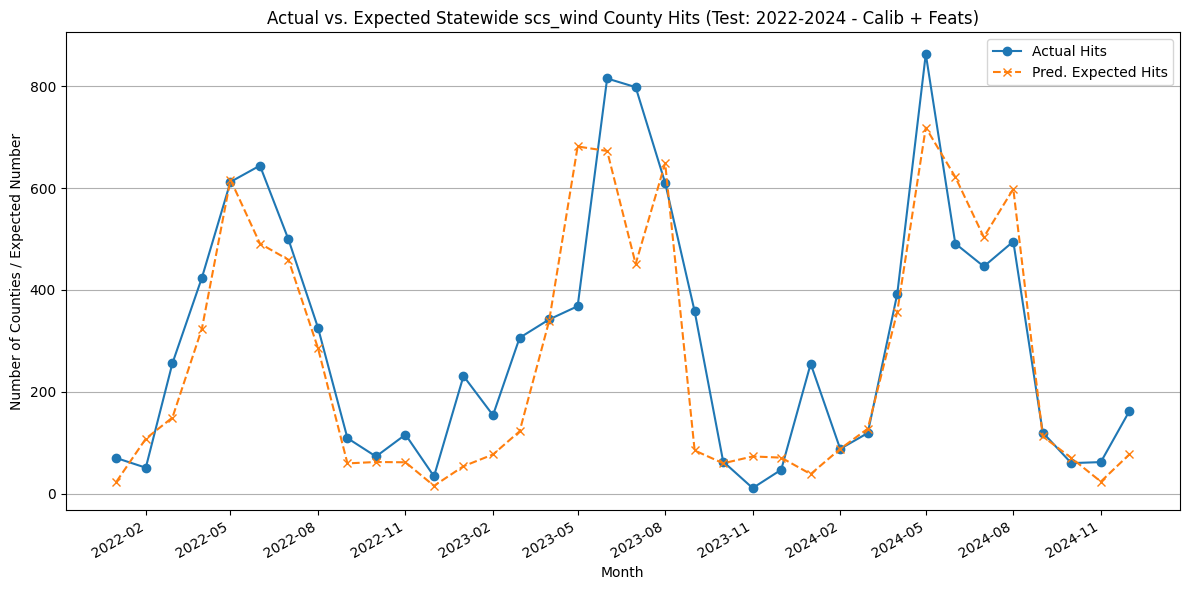

[2025-04-11 10:55:51] [INFO] ModelTrainingLoggerSCS_TargetStates - --- Statewide Monthly Expected Hit Evaluation Complete ---


In [11]:
# --- Cell 11: Evaluate Statewide Expected Monthly Hits (Sum of Probabilities - Calibrated SCS Wind) ---

logger.info(f"Evaluating calibrated model's ability to predict statewide expected {TARGET_EVENT_TYPE} hits...")

try:
    # Load calibrated model if needed
    model_to_eval = None
    if 'calibrated_clf' in locals() and calibrated_clf is not None: model_to_eval = calibrated_clf
    else:
        MODEL_PATH = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_AnomInd_lgbm_calibrated.joblib")
        if os.path.exists(MODEL_PATH): model_to_eval = joblib.load(MODEL_PATH); logger.info("Loaded calibrated model.")
        else: raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

    if 'X_test_scaled' not in locals() or 'y_test' not in locals() or 'test_identifiers' not in locals(): raise NameError("Test data missing.")
    if X_test_scaled.shape[0] == 0: logger.warning("Test set empty."); raise ValueError("Test set empty.")

    # Get Predicted Probabilities from CALIBRATED model
    logger.debug("Predicting probabilities...")
    pred_proba = model_to_eval.predict_proba(X_test_scaled)[:, 1]

    # --- Combine, Calculate Counts/Sums, Evaluate, Plot (Logic is the same, just update titles/filenames) ---
    logger.debug("Combining probabilities...")
    df_test_results = test_identifiers.copy(); df_test_results.reset_index(drop=True, inplace=True)
    df_test_results['actual_occurred'] = y_test.values; df_test_results['predicted_proba'] = pred_proba

    logger.debug("Calculating monthly counts/sums...")
    df_test_results['time'] = pd.to_datetime(df_test_results['time']); df_test_results['YearMonth'] = df_test_results['time'].dt.to_period('M')
    actual_monthly_counts = df_test_results.groupby('YearMonth')['actual_occurred'].sum().reset_index(); actual_monthly_counts.rename(columns={'actual_occurred': 'actual_county_hits'}, inplace=True)
    predicted_monthly_expected = df_test_results.groupby('YearMonth')['predicted_proba'].sum().reset_index(); predicted_monthly_expected.rename(columns={'predicted_proba': 'predicted_expected_hits'}, inplace=True)
    df_monthly_compare = pd.merge(actual_monthly_counts, predicted_monthly_expected, on='YearMonth', how='outer').fillna(0); df_monthly_compare['time'] = df_monthly_compare['YearMonth'].dt.to_timestamp()

    logger.info("Monthly counts/sums calculated.")
    print(f"\n--- Comparison: Actual Hits vs. Predicted Expected Hits ({TARGET_EVENT_TYPE} - Calibrated + Indices + Anoms) ---")
    display(df_monthly_compare[ df_monthly_compare['actual_county_hits'] > 0 ].sort_values('YearMonth'))
    print("\n--- Months with Highest Predicted Expected Hits ---")
    display(df_monthly_compare.nlargest(10, 'predicted_expected_hits'))

    # Evaluate Match
    from sklearn.metrics import mean_absolute_error, r2_score
    mae = mean_absolute_error(df_monthly_compare['actual_county_hits'], df_monthly_compare['predicted_expected_hits'])
    correlation = df_monthly_compare['actual_county_hits'].corr(df_monthly_compare['predicted_expected_hits'])
    try: r2 = r2_score(df_monthly_compare['actual_county_hits'], df_monthly_compare['predicted_expected_hits'])
    except ValueError: r2 = np.nan
    logger.info(f"Statewide Monthly Expected Hit ({TARGET_EVENT_TYPE} - Calibrated + Indices + Anoms) Perf:") # Updated log
    logger.info(f"  MAE: {mae:.4f}"); logger.info(f"  Correlation: {correlation:.4f}"); logger.info(f"  R-squared: {r2:.4f}")
    print(f"\nStatewide Monthly Expected Hit ({TARGET_EVENT_TYPE} - Calibrated + Indices + Anoms) Perf:") # Updated print
    print(f"  MAE: {mae:.4f}"); print(f"  Correlation: {correlation:.4f}"); print(f"  R-squared: {r2:.4f}")

    # Plot Comparison
    plot_filename = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_AnomInd_calib_statewide_count_comparison.png") # Updated filename
    plt.figure(figsize=(12, 6))
    plt.plot(df_monthly_compare['time'], df_monthly_compare['actual_county_hits'], label='Actual Hits', marker='o', linestyle='-', markersize=6)
    plt.plot(df_monthly_compare['time'], df_monthly_compare['predicted_expected_hits'], label='Pred. Expected Hits', marker='x', linestyle='--', markersize=6)
    plt.xlabel("Month"); plt.ylabel("Number of Counties / Expected Number")
    plt.title(f"Actual vs. Expected Statewide {TARGET_EVENT_TYPE} County Hits (Test: {TEST_YEAR_START}-{actual_max_test_year} - Calib + Feats)") # Updated title
    plt.legend(); plt.grid(True, axis='y'); import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)); plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')); plt.gcf().autofmt_xdate()
    plt.tight_layout(); plt.savefig(plot_filename); plt.show()

except Exception as e: logger.exception(f"Failed statewide evaluation: {e}")

logger.info("--- Statewide Monthly Expected Hit Evaluation Complete ---")

In [12]:
# --- Cell 12: Generate Future Projections (Using Calibrated Probs) ---
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.preprocessing import StandardScaler # Ensure imported
from sklearn.calibration import CalibratedClassifierCV # Ensure imported
import lightgbm as lgb # Ensure base estimator class is known if loading only CalibratedCV
import warnings

logger.info("--- Starting Future Projection Analysis (using Calibrated LGBM) ---")

# --- Configuration & Input Checks ---
# Ensure paths and variable names defined in Cell #2 are accessible
# MODEL_PATH should point to the saved calibrated LGBM model
MODEL_PATH = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_AnomInd_lgbm_calibrated.joblib")
# SCALER_PATH should point to the scaler fitted on AnomInd features
SCALER_PATH = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_states_scaler.joblib")
# Output path for projections CSV
OUTPUT_PROJECTIONS_PATH = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_CalibLGBM_projections.csv")

try:
    # Check if necessary variables from previous cells exist
    if 'X_future' not in locals() or X_future.empty:
        raise ValueError("Future feature data (X_future) missing or empty. Ensure Cell 6 ran successfully.")
    if 'future_identifiers' not in locals() or future_identifiers.empty:
         raise ValueError("Future identifiers DataFrame (future_identifiers) missing or empty. Ensure Cell 6 ran successfully.")
    if 'feature_cols' not in locals() or not feature_cols:
         raise ValueError("Feature column list (feature_cols) not found. Ensure Cell 5 ran successfully.")
    if not os.path.exists(MODEL_PATH): raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")
    if not os.path.exists(SCALER_PATH): raise FileNotFoundError(f"Scaler file not found: {SCALER_PATH}")
    # --- End Checks ---


    # --- Load Model and Scaler ---
    logger.info(f"Loading calibrated model from {MODEL_PATH}")
    calibrated_clf = joblib.load(MODEL_PATH)
    logger.info(f"Loading scaler from {SCALER_PATH}")
    scaler = joblib.load(SCALER_PATH)

    # --- Prepare and Scale Future Data ---
    logger.info(f"Preparing future data (shape: {X_future.shape})")
    # Ensure X_future has the correct columns in the correct order
    # Get expected feature names from scaler
    feature_names_ordered = scaler.feature_names_in_ if hasattr(scaler, 'feature_names_in_') else feature_cols
    missing_cols = [col for col in feature_names_ordered if col not in X_future.columns]
    if missing_cols: raise ValueError(f"X_future is missing columns expected by scaler: {missing_cols}")
    X_future_prep = X_future[feature_names_ordered].copy() # Use order from scaler

    logger.info("Scaling future features...")
    X_future_scaled = scaler.transform(X_future_prep) # Scale data with original names

    # --- Generate Predictions (Probabilities) ---
    logger.info("Generating future predicted probabilities...")
    with warnings.catch_warnings(): # Suppress potential feature name warnings
        warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")
        future_probs = calibrated_clf.predict_proba(X_future_scaled)[:, 1] # Predict P(Occurrence=1)

    # --- Add Predictions to Future DataFrame ---
    logger.info("Adding probabilities to future identifiers DataFrame...")
    df_future_preds = future_identifiers.copy()
    df_future_preds.reset_index(drop=True, inplace=True)
    if len(df_future_preds) != len(future_probs): raise ValueError(f"Length mismatch: identifiers vs probabilities")
    df_future_preds['predicted_prob'] = future_probs # Store probability
    logger.info("Future probabilities generated and added.")

    # --- Aggregate Expected Counts (Sum of Probabilities) per County/Year ---
    logger.info("Calculating future expected hits per county per year (Sum of Monthly Probs).")
    if 'year' not in df_future_preds.columns: # Add year if missing
        df_future_preds['time'] = pd.to_datetime(df_future_preds['time'])
        df_future_preds['year'] = df_future_preds['time'].dt.year

    # Group by county and year, summing the monthly probabilities
    df_future_annual_expected_hits = df_future_preds.groupby(['county_geoid', 'year'])['predicted_prob'].sum().reset_index()
    df_future_annual_expected_hits.rename(columns={'predicted_prob': 'total_expected_hits_per_year'}, inplace=True) # Sum of monthly probs = expected annual county hits
    logger.info("Calculated future expected annual hits per county.")
    print("\n--- Future Projected Expected Annual Hits (Sample) ---")
    display(df_future_annual_expected_hits.head())

    # --- Save Projections ---
    try:
        df_future_annual_expected_hits.to_csv(OUTPUT_PROJECTIONS_PATH, index=False)
        logger.info(f"Saved future annual projections to {OUTPUT_PROJECTIONS_PATH}")
    except Exception as e:
        logger.exception(f"Failed to save future projections: {e}")

except FileNotFoundError as fnf: logger.exception(f"{fnf}"); raise fnf
except ValueError as ve: logger.exception(f"ValueError: {ve}"); raise ve
except NameError as ne: logger.exception(f"Missing variable: {ne}"); raise ne
except Exception as e: logger.exception(f"Failed future projection: {e}"); raise e

logger.info("--- Future Projection Analysis Complete ---")

[2025-04-11 10:55:51] [INFO] ModelTrainingLoggerSCS_TargetStates - --- Starting Future Projection Analysis (using Calibrated LGBM) ---
[2025-04-11 10:55:51] [INFO] ModelTrainingLoggerSCS_TargetStates - Loading calibrated model from ../output/models\scs_wind_target_AnomInd_lgbm_calibrated.joblib
[2025-04-11 10:55:51] [INFO] ModelTrainingLoggerSCS_TargetStates - Loading scaler from ../output/models\scs_wind_target_states_scaler.joblib
[2025-04-11 10:55:51] [INFO] ModelTrainingLoggerSCS_TargetStates - Preparing future data (shape: (189948, 35))
[2025-04-11 10:55:51] [INFO] ModelTrainingLoggerSCS_TargetStates - Scaling future features...
[2025-04-11 10:55:51] [INFO] ModelTrainingLoggerSCS_TargetStates - Generating future predicted probabilities...
[2025-04-11 10:55:51] [INFO] ModelTrainingLoggerSCS_TargetStates - Adding probabilities to future identifiers DataFrame...
[2025-04-11 10:55:51] [INFO] ModelTrainingLoggerSCS_TargetStates - Future probabilities generated and added.
[2025-04-11 10


--- Future Projected Expected Annual Hits (Sample) ---


,county_geoid,year,total_expected_hits_per_year
0,01001,2025,2.128954
1,01001,2026,1.856894
2,01001,2027,2.248438
3,01001,2028,2.172485
4,01001,2029,2.454799


[2025-04-11 10:55:51] [INFO] ModelTrainingLoggerSCS_TargetStates - Saved future annual projections to ../output/models\scs_wind_target_CalibLGBM_projections.csv
[2025-04-11 10:55:51] [INFO] ModelTrainingLoggerSCS_TargetStates - --- Future Projection Analysis Complete ---


In [13]:
# --- Cell 13: Prepare Historical Data ---
logger.info("Preparing historical actual storm counts...")

# Requires df_events and target_geoids from Cell 3
if 'df_events' not in locals() or df_events.empty:
    raise ValueError("Event data (df_events) not found or empty. Ensure Cell 3 ran.")
if 'target_geoids' not in locals() or not target_geoids:
     raise ValueError("Florida GEOIDs (target_geoids) not found. Ensure Cell 3 ran.")

try:
    # Filter for Florida and the target event type for the historical period
    # Use a relevant historical range, e.g., 2014-2024
    hist_start_year = 2014
    hist_end_year = 2024 # Inclusive
    df_events_hist = df_events[
        (df_events['county_geoid'].isin(target_geoids)) &
        (df_events['event_type'] == TARGET_EVENT_TYPE) &
        (df_events['first_impact_dt'].dt.year >= hist_start_year) &
        (df_events['first_impact_dt'].dt.year <= hist_end_year)
    ].copy()
    df_events_hist['year'] = df_events_hist['first_impact_dt'].dt.year

    # Calculate actual counts per county per year
    df_hist_actual_hits = df_events_hist.groupby(['county_geoid', 'year']).size().reset_index(name='actual_hits')

    # --- Create a complete index of county-years for the historical period ---
    all_hist_years = range(hist_start_year, hist_end_year + 1)
    hist_full_index = pd.MultiIndex.from_product([target_geoids, all_hist_years], names=['county_geoid', 'year'])
    df_hist_full = pd.DataFrame(index=hist_full_index).reset_index()

    # Merge actual counts, fill missing county-years with 0 hits
    df_hist_actual_hits_full = pd.merge(df_hist_full, df_hist_actual_hits, on=['county_geoid', 'year'], how='left')
    df_hist_actual_hits_full['actual_hits'].fillna(0, inplace=True)
    df_hist_actual_hits_full['actual_hits'] = df_hist_actual_hits_full['actual_hits'].astype(int)

    logger.info(f"Calculated historical actual hits per county per year ({hist_start_year}-{hist_end_year}).")
    display(df_hist_actual_hits_full.head())

except Exception as e:
    logger.exception(f"Failed during historical data preparation: {e}")
    raise e

[2025-04-11 10:55:52] [INFO] ModelTrainingLoggerSCS_TargetStates - Preparing historical actual storm counts...
C:\Users\60864\AppData\Local\Temp\ipykernel_29260\2908585131.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_hist_actual_hits_full['actual_hits'].fillna(0, inplace=True)
[2025-04-11 10:55:52] [INFO] ModelTrainingLoggerSCS_TargetStates - Calculated historical actual hits per county per year (2014-2024).


,county_geoid,year,actual_hits
0,01001,2014,5
1,01001,2015,3
2,01001,2016,2
3,01001,2017,3
4,01001,2018,3


In [14]:
# --- Cell 14: Calculate Metrics and Display Table ---
logger.info("Calculating summary metrics and CAGR...")

def calculate_cagr(start_value, end_value, num_years):
    """Calculates Compound Annual Growth Rate, handling zero start."""
    # Ensure inputs are numeric and valid
    start_value = pd.to_numeric(start_value, errors='coerce')
    end_value = pd.to_numeric(end_value, errors='coerce')

    if pd.isna(start_value) or pd.isna(end_value) or num_years <= 0:
        return np.nan
    if start_value <= 0:
        # Handle zero or negative start value - CAGR is undefined or infinite/complex
        # Return NaN or a large number, or based on specific business logic
        if end_value > 0: return np.inf # Growth from zero is infinite
        else: return 0.0 # No growth if start and end are zero/negative
    # Proceed with standard calculation
    return ((end_value / start_value)**(1 / num_years)) - 1

df_future_expected_hits = df_future_annual_expected_hits

try:
    # --- Validate required input DataFrames ---
    if 'df_hist_actual_hits_full' not in locals() or df_hist_actual_hits_full.empty:
        raise ValueError("Historical hits data (df_hist_actual_hits_full) missing or empty.")
    if 'df_future_expected_hits' not in locals() or df_future_expected_hits.empty:
        raise ValueError("Future expected hits data (df_future_expected_hits) missing or empty.")

    # --- Calculate Historical Average & Total ---
    hist_start_year = 2014 # Make sure these match Cell 13
    hist_end_year = 2024
    num_hist_years = hist_end_year - hist_start_year # Periods for CAGR

    df_hist_summary = df_hist_actual_hits_full.groupby('county_geoid')['actual_hits'].agg(
        hist_avg_hits_per_year='mean',
        hist_total_hits='sum'
        # Removed lambda functions for start/end here
    ).reset_index()

    # --- Get Start and End Year Historical Hits Separately ---
    df_hist_start = df_hist_actual_hits_full[df_hist_actual_hits_full['year'] == hist_start_year][['county_geoid', 'actual_hits']].rename(columns={'actual_hits':'hist_start_hits'})
    df_hist_end = df_hist_actual_hits_full[df_hist_actual_hits_full['year'] == hist_end_year][['county_geoid', 'actual_hits']].rename(columns={'actual_hits':'hist_end_hits'})

    # --- Merge Start/End Hits onto Summary ---
    df_hist_summary = pd.merge(df_hist_summary, df_hist_start, on='county_geoid', how='left')
    df_hist_summary = pd.merge(df_hist_summary, df_hist_end, on='county_geoid', how='left')
    # Fill potentially missing start/end year values with 0 before CAGR calc
    df_hist_summary['hist_start_hits'].fillna(0, inplace=True)
    df_hist_summary['hist_end_hits'].fillna(0, inplace=True)

    # Calculate historical CAGR
    if num_hist_years > 0:
        df_hist_summary['CAGR_2014_2024'] = df_hist_summary.apply(
            lambda row: calculate_cagr(row['hist_start_hits'], row['hist_end_hits'], num_hist_years), axis=1
        )
    else:
         df_hist_summary['CAGR_2014_2024'] = np.nan # Avoid calculation if only one year
         logger.warning("Historical period is only one year or less, cannot calculate CAGR.")

    # --- Calculate Future Average Expected & Projected CAGR ---
    future_start_year = 2025 # First full year of projection
    future_end_year = 2035   # Last full year of projection
    num_future_years = future_end_year - future_start_year

    # Check if future data actually covers the required range
    if df_future_expected_hits['year'].min() > future_start_year or df_future_expected_hits['year'].max() < future_end_year:
         logger.warning(f"Future data does not cover the full range {future_start_year}-{future_end_year}. CAGR might be inaccurate or NaN.")

    df_future_filtered = df_future_expected_hits[
        (df_future_expected_hits['year'] >= future_start_year) &
        (df_future_expected_hits['year'] <= future_end_year)
    ]

    # --- Calculate Future Average ---
    df_future_summary = df_future_filtered.groupby('county_geoid')['total_expected_hits_per_year'].agg(
        future_avg_expected_hits_per_year='mean'
    ).reset_index()

    # --- Get Start and End Year Future Expected Hits Separately ---
    df_future_start = df_future_expected_hits[df_future_expected_hits['year'] == future_start_year][['county_geoid', 'total_expected_hits_per_year']].rename(columns={'total_expected_hits_per_year':'future_start_expected_hits'})
    df_future_end = df_future_expected_hits[df_future_expected_hits['year'] == future_end_year][['county_geoid', 'total_expected_hits_per_year']].rename(columns={'total_expected_hits_per_year':'future_end_expected_hits'})

    # --- Merge Start/End Future Hits onto Summary ---
    df_future_summary = pd.merge(df_future_summary, df_future_start, on='county_geoid', how='left')
    df_future_summary = pd.merge(df_future_summary, df_future_end, on='county_geoid', how='left')
    # Fill potentially missing start/end year values with 0 before CAGR calc
    df_future_summary['future_start_expected_hits'].fillna(0, inplace=True)
    df_future_summary['future_end_expected_hits'].fillna(0, inplace=True)

    # Calculate future projected CAGR
    if num_future_years > 0:
        df_future_summary['Proj_CAGR_2025_2035'] = df_future_summary.apply(
            lambda row: calculate_cagr(row['future_start_expected_hits'], row['future_end_expected_hits'], num_future_years), axis=1
        )
    else:
         df_future_summary['Proj_CAGR_2025_2035'] = np.nan
         logger.warning("Future period is only one year or less, cannot calculate CAGR.")


    # --- Combine Historical and Future Summaries ---
    logger.info("Combining historical and future summaries...")
    df_summary = pd.merge(df_hist_summary, df_future_summary, on='county_geoid', how='left') # Use left to keep all historical counties

    # Select and order columns for display
    display_cols = [
        'county_geoid',
        'hist_avg_hits_per_year',
        'CAGR_2014_2024',
        'future_avg_expected_hits_per_year',
        'Proj_CAGR_2025_2035'
    ]
    # Ensure columns exist before selecting
    display_cols = [col for col in display_cols if col in df_summary.columns]
    df_summary_display = df_summary[display_cols].copy()

    # Format for better readability
    if 'hist_avg_hits_per_year' in df_summary_display: df_summary_display['hist_avg_hits_per_year'] = df_summary_display['hist_avg_hits_per_year'].map('{:.2f}'.format)
    if 'future_avg_expected_hits_per_year' in df_summary_display: df_summary_display['future_avg_expected_hits_per_year'] = df_summary_display['future_avg_expected_hits_per_year'].map('{:.2f}'.format)
    if 'CAGR_2014_2024' in df_summary_display: df_summary_display['CAGR_2014_2024'] = df_summary_display['CAGR_2014_2024'].map('{:.2%}'.format)
    if 'Proj_CAGR_2025_2035' in df_summary_display: df_summary_display['Proj_CAGR_2025_2035'] = df_summary_display['Proj_CAGR_2025_2035'].map('{:.2%}'.format)


    logger.info("--- Historical vs Future Projected Summary Table ---")
    # Display the summary table
    with pd.option_context('display.max_rows', 20, 'display.max_columns', None): # Show all rows/cols
        display(df_summary_display)

except Exception as e:
    logger.exception(f"Failed during summary calculation: {e}")
    raise e

[2025-04-11 10:55:52] [INFO] ModelTrainingLoggerSCS_TargetStates - Calculating summary metrics and CAGR...
C:\Users\60864\AppData\Local\Temp\ipykernel_29260\611133845.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_hist_summary['hist_start_hits'].fillna(0, inplace=True)
C:\Users\60864\AppData\Local\Temp\ipykernel_29260\611133845.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace met

,county_geoid,hist_avg_hits_per_year,CAGR_2014_2024,future_avg_expected_hits_per_year,Proj_CAGR_2025_2035
0,01001,3.27,-8.76%,2.18,-0.96%
1,01003,10.27,14.87%,2.54,-0.69%
2,01005,2.73,11.61%,2.23,-0.57%
3,01007,2.09,2.92%,2.15,1.29%
4,01009,7.18,-1.81%,2.98,0.64%
...,...,...,...,...,...
1434,51800,4.27,-10.40%,1.49,1.04%
1435,51810,6.55,-5.25%,1.71,0.14%
1436,51820,0.82,inf%,2.38,-1.03%
1437,51830,0.64,inf%,1.71,0.14%


In [15]:
# --- Cell 15: Load US GeoData, Filter TARGET STATES, Prepare for Map ---
import geopandas as gpd
import matplotlib.pyplot as plt
import os # Ensure os is imported if not already

logger.info("Loading US county geospatial data and filtering for TARGET states...")

# --- Configuration (Use paths/names defined in Cell #2) ---
US_COUNTY_SHAPEFILE_PATH = COUNTY_SHAPEFILE_PATH # Defined in Cell #2
GEOID_COLUMN_IN_SHAPEFILE = "GEOID" # Defined in Cell #2
STATE_FIPS_COLUMN_IN_SHAPEFILE = "STATEFP" # Defined in Cell #2
# target_state_fips list is defined in Cell #2

MAP_YEAR_START = 2025
MAP_YEAR_END = 2035

gdf_target_states_merged = None # Initialize # Renamed variable

try:
    # --- Check required input variables ---
    if 'target_state_fips' not in locals() or not target_state_fips:
         raise NameError("List of target_state_fips not found. Ensure Cell #2 ran.")
    if 'df_future_summary' not in locals() or df_future_summary.empty:
         raise NameError("df_future_summary not found or empty. Ensure Cell #14 ran successfully.")

    # --- Load US County Boundaries ---
    logger.info(f"Loading US polygons from: {US_COUNTY_SHAPEFILE_PATH}")
    if not os.path.exists(US_COUNTY_SHAPEFILE_PATH):
        raise FileNotFoundError(f"US County Shapefile not found at {US_COUNTY_SHAPEFILE_PATH}.")
    gdf_us_counties = gpd.read_file(US_COUNTY_SHAPEFILE_PATH)
    logger.info(f"Loaded GeoDataFrame with {len(gdf_us_counties)} US geometries. CRS: {gdf_us_counties.crs}")

    # --- Check required columns ---
    if GEOID_COLUMN_IN_SHAPEFILE not in gdf_us_counties.columns:
        raise ValueError(f"GEOID column '{GEOID_COLUMN_IN_SHAPEFILE}' not found.")
    if STATE_FIPS_COLUMN_IN_SHAPEFILE not in gdf_us_counties.columns:
        raise ValueError(f"State FIPS column '{STATE_FIPS_COLUMN_IN_SHAPEFILE}' not found.")

    # --- Filter for TARGET STATES using the list --- ## CORRECTED FILTER ##
    logger.info(f"Filtering for State FIPS in list: {target_state_fips}")
    gdf_us_counties[STATE_FIPS_COLUMN_IN_SHAPEFILE] = gdf_us_counties[STATE_FIPS_COLUMN_IN_SHAPEFILE].astype(str).str.strip()
    # Use .isin() to filter for multiple states in the list
    gdf_target_states = gdf_us_counties[gdf_us_counties[STATE_FIPS_COLUMN_IN_SHAPEFILE].isin(target_state_fips)].copy() # Renamed variable
    if gdf_target_states.empty:
         raise ValueError(f"No counties found for State FIPS list: {target_state_fips}")
    logger.info(f"Filtered down to {len(gdf_target_states)} counties in target states.")
    # --- End Correction ---

    # --- Prepare GeoDataFrame for Merging ---
    # Use the filtered dataframe gdf_target_states
    gdf_target_states.rename(columns={GEOID_COLUMN_IN_SHAPEFILE: 'county_geoid'}, inplace=True)
    gdf_target_states['county_geoid'] = gdf_target_states['county_geoid'].astype(str).str.strip().str.zfill(5)
    gdf_target_states = gdf_target_states[['county_geoid', 'geometry']].copy()
    gdf_target_states.drop_duplicates(subset=['county_geoid'], inplace=True)

    # --- Calculate Projected Change (using df_future_summary from Cell #14) ---
    # This part remains the same
    df_map_data = df_future_summary[['county_geoid', 'future_start_expected_hits', 'future_end_expected_hits']].copy()
    epsilon = 1e-6
    df_map_data['proj_change_pct'] = (
        (df_map_data['future_end_expected_hits'] - df_map_data['future_start_expected_hits']) /
        (df_map_data['future_start_expected_hits'] + epsilon) * 100
    )
    logger.info("Calculated projected percentage change (2035 vs 2025).")

    # --- Merge Map Data with Target States GeoDataFrame ---
    logger.info("Merging projection change data onto target state county geometries...")
    # Use left merge on gdf_target_states
    gdf_target_states_merged = gdf_target_states.merge(df_map_data, on='county_geoid', how='left') # Renamed variable

    # Check merge success
    missing_projection_count = gdf_target_states_merged['proj_change_pct'].isnull().sum()
    if missing_projection_count > 0:
         missing_counties = gdf_target_states_merged[gdf_target_states_merged['proj_change_pct'].isnull()]['county_geoid'].tolist()
         logger.warning(f"Could not find projection data for {missing_projection_count} counties: {missing_counties[:10]}... They will appear blank.")
         # Optional: Fill NaN
         # gdf_target_states_merged['proj_change_pct'].fillna(0, inplace=True)

    logger.info("Map data preparation complete.")
    display(gdf_target_states_merged[['county_geoid', 'proj_change_pct', 'geometry']].head())

except FileNotFoundError as fnf: logger.error(f"{fnf}")
except ValueError as ve: logger.error(f"Data processing error: {ve}")
except NameError as ne: logger.error(f"Required variable not found: {ne}.")
except Exception as e:
    logger.exception(f"Failed during GeoData loading or preparation: {e}")
    gdf_target_states_merged = None # Ensure set to None on error
    raise e

[2025-04-11 10:55:52] [INFO] ModelTrainingLoggerSCS_TargetStates - Loading US county geospatial data and filtering for TARGET states...
[2025-04-11 10:55:52] [INFO] ModelTrainingLoggerSCS_TargetStates - Loading US polygons from: ../data/geospatial/tl_2024_us_county.shp
[2025-04-11 10:55:53] [INFO] ModelTrainingLoggerSCS_TargetStates - Loaded GeoDataFrame with 3235 US geometries. CRS: EPSG:4269
[2025-04-11 10:55:53] [INFO] ModelTrainingLoggerSCS_TargetStates - Filtering for State FIPS in list: ['12', '20', '29', '40', '48', '05', '22', '28', '01', '13', '45', '37', '47', '51']
[2025-04-11 10:55:53] [INFO] ModelTrainingLoggerSCS_TargetStates - Filtered down to 1439 counties in target states.
[2025-04-11 10:55:53] [INFO] ModelTrainingLoggerSCS_TargetStates - Calculated projected percentage change (2035 vs 2025).
[2025-04-11 10:55:53] [INFO] ModelTrainingLoggerSCS_TargetStates - Merging projection change data onto target state county geometries...
[2025-04-11 10:55:53] [INFO] ModelTraining

,county_geoid,proj_change_pct,geometry
0,48327,-39.633005,"POLYGON ((-99.7712 30.71079, -99.7824 30.71078..."
1,48189,26.127805,"POLYGON ((-102.09042 34.31313, -102.0889 34.31..."
2,01027,3.392359,"POLYGON ((-85.97876 33.32813, -85.97854 33.332..."
3,48011,-1.186808,"POLYGON ((-101.62512 35.0007, -101.62509 35.00..."
4,13189,-1.246532,"POLYGON ((-82.6497 33.60877, -82.64954 33.6087..."


[2025-04-11 10:55:53] [INFO] ModelTrainingLoggerSCS_TargetStates - Generating target states projected change map...
[2025-04-11 10:55:58] [INFO] ModelTrainingLoggerSCS_TargetStates - Map saved successfully to ../output/models\scs_wind_target_states_proj_change_map.png


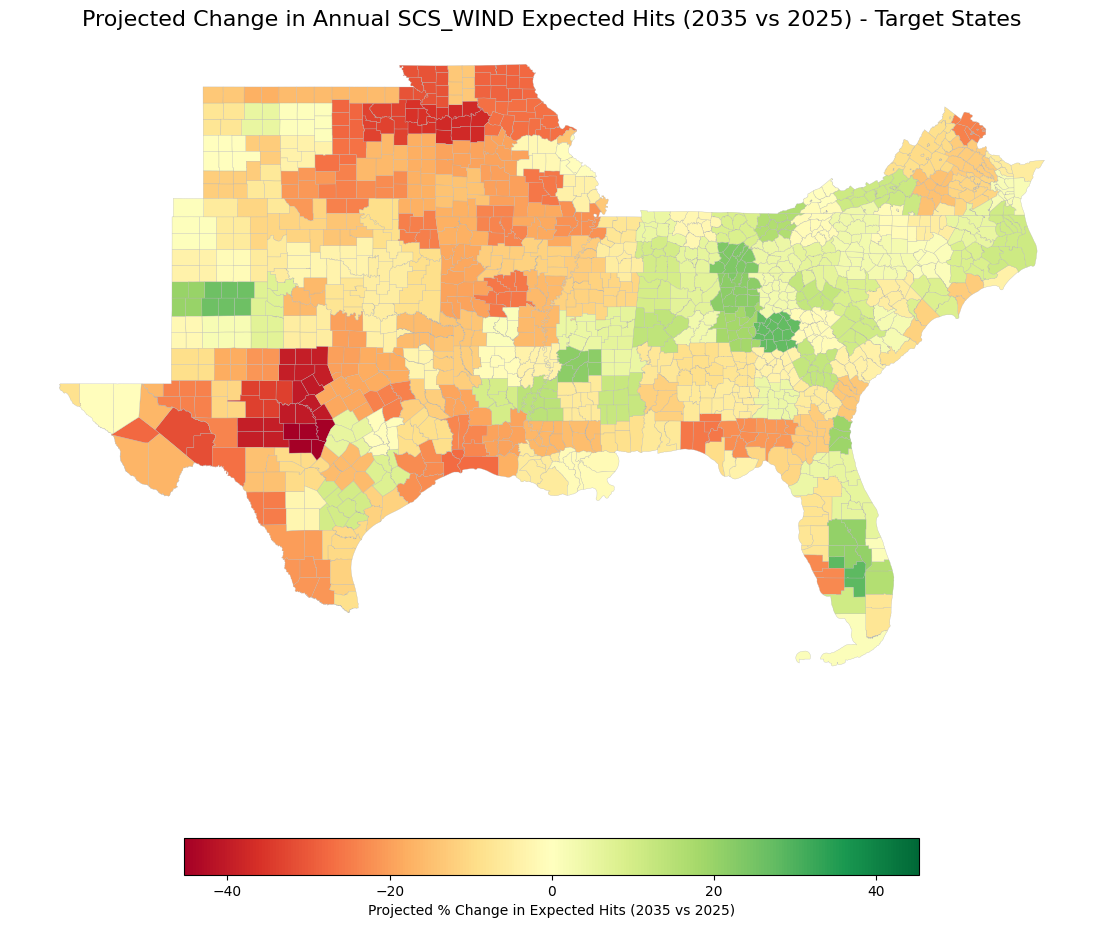

In [16]:
# --- Cell 16: Create Target States Choropleth Map ---
import matplotlib.pyplot as plt # Ensure imported
import geopandas as gpd # Ensure imported
import os # Ensure imported

logger.info("Generating target states projected change map...")

try:
    # --- Use the CORRECT variable name from Cell 15 ---
    if 'gdf_target_states_merged' not in locals() or gdf_target_states_merged is None:
        raise NameError("gdf_target_states_merged not found or is None. Ensure Cell 15 ran successfully.")
    if gdf_target_states_merged.empty:
        logger.warning("Map data GeoDataFrame is empty. Skipping map generation.")
    else:
        # --- Create the Plot ---
        fig, ax = plt.subplots(1, 1, figsize=(15, 10)) # Adjust figure size for multiple states

        # Define color map: Red for decrease, Green for increase
        cmap = 'RdYlGn'
        # Determine symmetric color limits (handle potential NaNs in percentile calc)
        max_abs_change = gdf_target_states_merged['proj_change_pct'].abs().max()
        if pd.isna(max_abs_change) or max_abs_change == 0: # Handle case where change is zero or all NaN
            vmin, vmax = -1, 1 # Set arbitrary small range if no variation
        else:
             vmin = -max_abs_change
             vmax = max_abs_change

        # Plot the choropleth using the CORRECT variable
        gdf_target_states_merged.plot(column='proj_change_pct',
                           cmap=cmap,
                           linewidth=0.2, # Thinner lines for potentially more counties
                           ax=ax,
                           edgecolor='0.7', # Lighter edge color
                           legend=True,
                           legend_kwds={'label': f"Projected % Change in Expected Hits ({MAP_YEAR_END} vs {MAP_YEAR_START})",
                                        'orientation': "horizontal",
                                        'shrink': 0.5},
                           missing_kwds={'color': 'lightgrey', "label": "Missing Data"},
                           vmin=vmin, vmax=vmax)

        # --- Customize Appearance ---
        # Update Title
        ax.set_title(f'Projected Change in Annual {TARGET_EVENT_TYPE.upper()} Expected Hits ({MAP_YEAR_END} vs {MAP_YEAR_START}) - Target States', fontsize=16)
        ax.set_axis_off()
        plt.tight_layout()

        # Save the figure with updated name
        map_filename = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_states_proj_change_map.png")
        plt.savefig(map_filename, dpi=300, bbox_inches='tight')
        logger.info(f"Map saved successfully to {map_filename}")

        plt.show() # Display plot

except NameError as ne:
    logger.error(f"Required variable not found: {ne}. Ensure previous cells ran.")
except Exception as e:
    logger.exception(f"Failed during map generation: {e}")
    # Avoid raising here if you want subsequent cells to potentially run
    # raise e

[2025-04-11 10:56:00] [INFO] ModelTrainingLoggerSCS_TargetStates - Generating statewide PREDICTED aggregate monthly and yearly bar charts...
[2025-04-11 10:56:00] [INFO] ModelTrainingLoggerSCS_TargetStates - Preparing monthly aggregate prediction data...
[2025-04-11 10:56:00] [INFO] ModelTrainingLoggerSCS_TargetStates - Monthly predicted aggregate data prepared.
[2025-04-11 10:56:00] [INFO] ModelTrainingLoggerSCS_TargetStates - Creating monthly bar chart of predicted expected hits...
[2025-04-11 10:56:01] [INFO] ModelTrainingLoggerSCS_TargetStates - Monthly predicted hits bar chart saved to ../output/models\scs_wind_target_statewide_monthly_PREDICTED_comparison.png


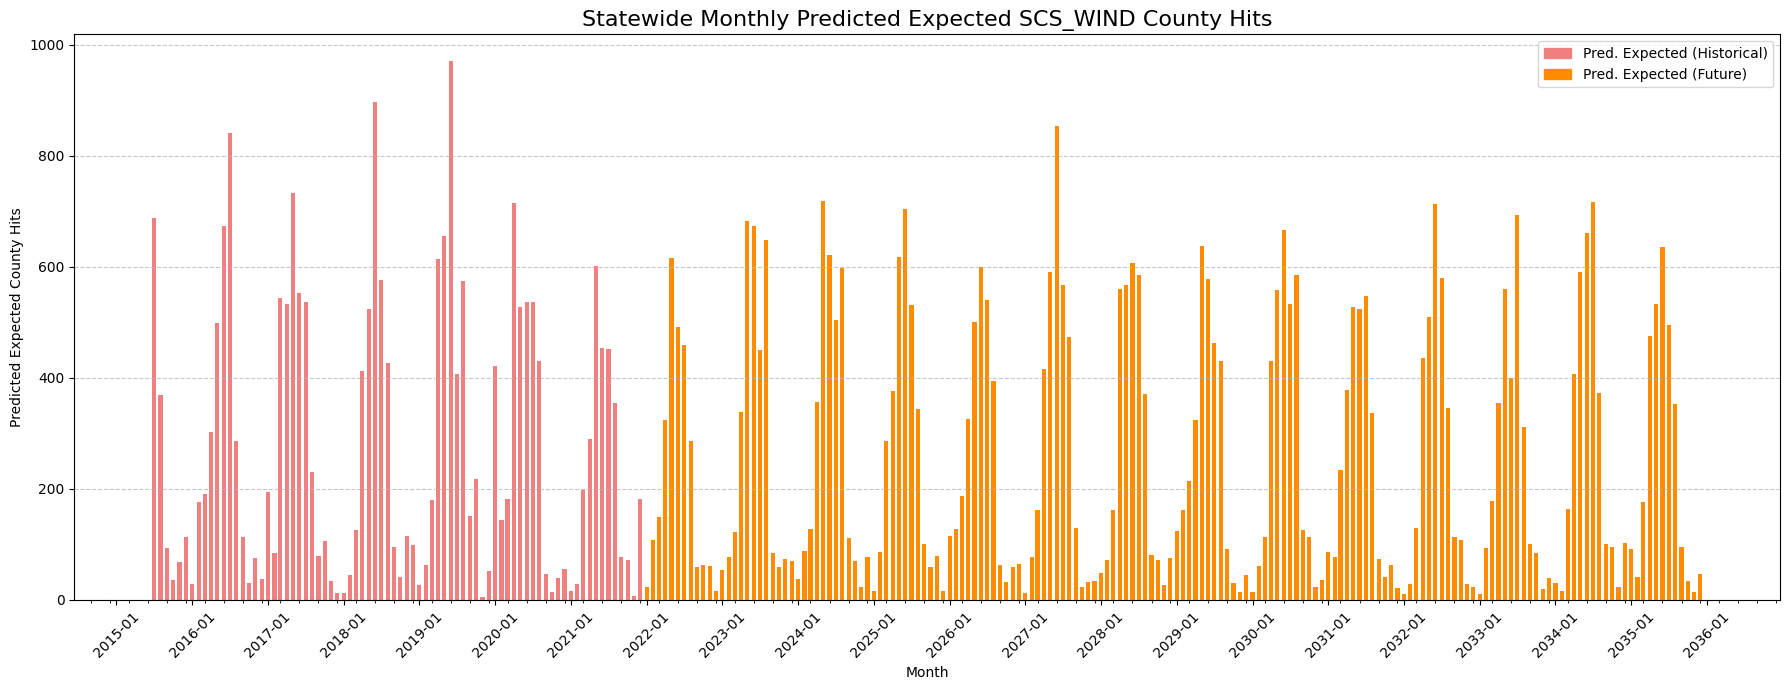

[2025-04-11 10:56:01] [INFO] ModelTrainingLoggerSCS_TargetStates - Preparing yearly aggregate prediction data...
[2025-04-11 10:56:01] [INFO] ModelTrainingLoggerSCS_TargetStates - Yearly predicted aggregate data prepared.


,year,hist_pred_expected_hits,county_geoid,future_expected_hits,predicted_expected_hits
15804,2035,NaN,51540,2.214161,2.214161
15803,2035,NaN,51530,2.214161,2.214161
14410,2035,NaN,01021,1.933782,1.933782
14409,2035,NaN,01019,2.769896,2.769896
15810,2035,NaN,51600,1.880191,1.880191
15809,2035,NaN,51595,2.139289,2.139289
15808,2035,NaN,51590,2.513359,2.513359
15832,2035,NaN,51775,2.454084,2.454084
15833,2035,NaN,51790,2.214161,2.214161
15834,2035,NaN,51800,1.525330,1.525330


[2025-04-11 10:56:01] [INFO] ModelTrainingLoggerSCS_TargetStates - Calculating projected CAGR for 2025-2034 from predicted totals...
[2025-04-11 10:56:01] [INFO] ModelTrainingLoggerSCS_TargetStates - Predicted CAGR (2025-2034): -1.98%
[2025-04-11 10:56:01] [INFO] ModelTrainingLoggerSCS_TargetStates - Creating yearly bar chart of predicted expected hits...



Predicted CAGR (2025-2034): -1.98%


C:\Users\60864\AppData\Local\Temp\ipykernel_29260\1950917879.py:159: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(yearly_chart_path, dpi=300, bbox_inches='tight')
[2025-04-11 10:56:30] [INFO] ModelTrainingLoggerSCS_TargetStates - Yearly predicted hits bar chart saved to ../output/models\scs_wind_target_statewide_YEARLY_PREDICTED_comparison.png


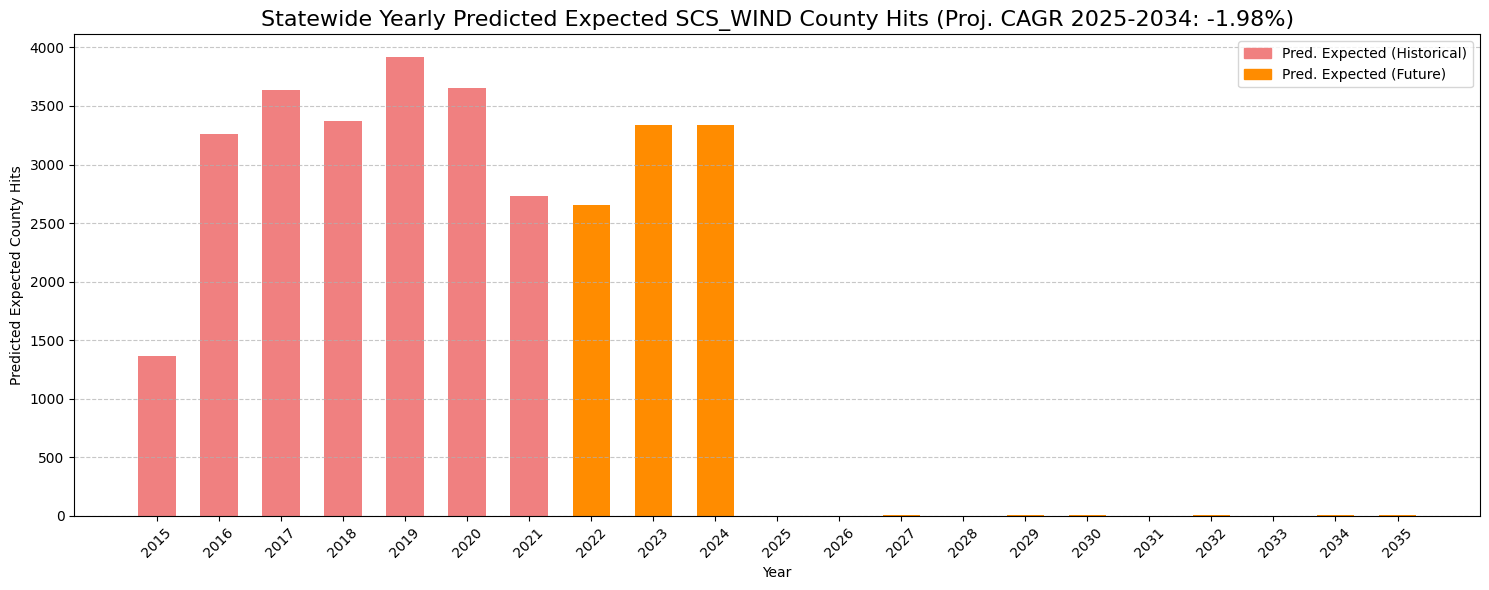

In [17]:
# --- Cell 17: Statewide PREDICTED Monthly and Yearly Aggregate Bar Charts ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

logger.info("Generating statewide PREDICTED aggregate monthly and yearly bar charts...")

try:
    # --- Validate required input DataFrames ---
    # Need historical predictions (created in Cell 10/10.5)
    if 'df_hist_monthly_expected' not in locals() or df_hist_monthly_expected.empty:
        raise NameError("df_hist_monthly_expected missing. Ensure Cell 10 ran.")
    # Need future predictions (created by aggregating df_future_preds from Cell 12)
    if 'df_future_preds' not in locals() or df_future_preds.empty:
        raise ValueError("Future predictions data (df_future_preds) missing. Cell 12 needed.")
    # Need future YEARLY predictions for CAGR context in yearly plot title (Cell 12)
    if 'df_future_annual_expected_hits' not in locals() or df_future_annual_expected_hits.empty:
        raise ValueError("Future yearly expected hits data (df_future_annual_expected_hits) missing.")
    # Need historical YEARLY actuals for CAGR context in yearly plot title (Cell 13/14)
    # This assumes df_hist_actual_hits_full holds YEARLY counts after Cell 13/14 adjustments
    if 'df_hist_actual_hits_full' not in locals() or df_hist_actual_hits_full.empty:
         logger.warning("Historical actual hits missing, cannot calculate historical CAGR for title.")
         df_hist_actual_hits_full = pd.DataFrame({'year':[], 'actual_hits':[]}) # Placeholder


    # --- 1. Prepare Monthly Aggregate Prediction Data ---
    logger.info("Preparing monthly aggregate prediction data...")
    # Future Expected Monthly Counts
    df_future_preds['time'] = pd.to_datetime(df_future_preds['time'])
    df_future_monthly_expected = df_future_preds.groupby(pd.Grouper(key='time', freq='MS'))['predicted_prob'].sum().reset_index()
    df_future_monthly_expected.rename(columns={'predicted_prob': 'future_expected_hits'}, inplace=True)

    # Historical Expected Monthly Counts (Use df created in Cell 10/10.5)
    df_hist_monthly_expected = df_hist_monthly_expected.rename(columns={'hist_expected_hits': 'hist_pred_expected_hits'})
    df_hist_monthly_expected['time'] = pd.to_datetime(df_hist_monthly_expected['time']) # Ensure datetime

    # Combine Historical and Future PREDICTIONS ONLY
    logger.debug("Merging historical and future predicted monthly series...")
    df_monthly_pred_agg = pd.merge(df_hist_monthly_expected[['time', 'hist_pred_expected_hits']],
                                   df_future_monthly_expected[['time', 'future_expected_hits']],
                                   on='time', how='outer')
    # Combine into a single prediction column
    df_monthly_pred_agg['predicted_expected_hits'] = df_monthly_pred_agg['future_expected_hits'].fillna(
        df_monthly_pred_agg['hist_pred_expected_hits']
    )
    df_monthly_pred_agg.sort_values('time', inplace=True)
    logger.info("Monthly predicted aggregate data prepared.")


    # --- 2. Create Monthly Bar Chart (Predictions Only) ---
    logger.info("Creating monthly bar chart of predicted expected hits...")
    fig_m, ax_m = plt.subplots(figsize=(18, 7))

    bar_width_total = 20

    # Plot combined predictions
    pred_mask_m = df_monthly_pred_agg['predicted_expected_hits'].notna()
    time_pred = df_monthly_pred_agg.loc[pred_mask_m, 'time']
    # Color historical and future differently for context
    colors = ['lightcoral' if yr <= TRAIN_YEAR_END else 'darkorange' for yr in time_pred.dt.year] # Assumes TRAIN_YEAR_END available

    ax_m.bar(time_pred,
             df_monthly_pred_agg.loc[pred_mask_m, 'predicted_expected_hits'],
             width=bar_width_total,
             label='Pred. Expected Hits (Hist: lightcoral, Future: orange)', # Unified label
             align='center', # Center bars on month start
             color=colors) # Apply conditional colors

    # Create manual legend handles
    import matplotlib.patches as mpatches
    hist_patch = mpatches.Patch(color='lightcoral', label='Pred. Expected (Historical)')
    future_patch = mpatches.Patch(color='darkorange', label='Pred. Expected (Future)')


    ax_m.set_title(f'Statewide Monthly Predicted Expected {TARGET_EVENT_TYPE.upper()} County Hits', fontsize=16)
    ax_m.set_xlabel("Month")
    ax_m.set_ylabel("Predicted Expected County Hits")
    ax_m.legend(handles=[hist_patch, future_patch]) # Use manual handles
    ax_m.grid(axis='y', linestyle='--', alpha=0.7)
    ax_m.xaxis.set_major_locator(mdates.YearLocator(1)) # Ticks every year
    ax_m.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax_m.xaxis.set_minor_locator(mdates.MonthLocator(interval=3)) # Minor ticks
    plt.xticks(rotation=45)
    plt.tight_layout()
    monthly_chart_path = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_statewide_monthly_PREDICTED_comparison.png") # New filename
    plt.savefig(monthly_chart_path)
    logger.info(f"Monthly predicted hits bar chart saved to {monthly_chart_path}")
    plt.show()


    # --- 3. Prepare Yearly Aggregate Prediction Data ---
    logger.info("Preparing yearly aggregate prediction data...")
    # Aggregate historical predictions by year
    df_hist_results_full['year'] = df_hist_results_full['time'].dt.year # Ensure year column exists
    df_hist_yearly_expected = df_hist_results_full.groupby('year')['predicted_proba'].sum().reset_index()
    df_hist_yearly_expected.rename(columns={'predicted_proba': 'hist_pred_expected_hits'}, inplace=True)

    # Use Future Expected Yearly Counts (already aggregated state-wide)
    df_future_yearly_expected = df_future_annual_expected_hits.rename(columns={'total_expected_hits_per_year': 'future_expected_hits'})

    # Combine Yearly Predicted Data
    df_yearly_pred_agg = pd.merge(df_hist_yearly_expected, df_future_yearly_expected, on='year', how='outer')
    # Combine into single prediction column
    df_yearly_pred_agg['predicted_expected_hits'] = df_yearly_pred_agg['future_expected_hits'].fillna(
        df_yearly_pred_agg['hist_pred_expected_hits']
    )
    df_yearly_pred_agg.sort_values('year', inplace=True)
    logger.info("Yearly predicted aggregate data prepared.")
    display(df_yearly_pred_agg.tail(15)) # Show recent history + future predictions

    # --- Recalculate Future CAGR (2025-2034) using predicted totals ---
    logger.info("Calculating projected CAGR for 2025-2034 from predicted totals...")
    cagr_start_year = 2025; cagr_end_year = 2034; num_cagr_years = cagr_end_year - cagr_start_year
    start_val = df_yearly_pred_agg[df_yearly_pred_agg['year'] == cagr_start_year]['predicted_expected_hits'].iloc[0] if not df_yearly_pred_agg[df_yearly_pred_agg['year'] == cagr_start_year].empty else np.nan
    end_val = df_yearly_pred_agg[df_yearly_pred_agg['year'] == cagr_end_year]['predicted_expected_hits'].iloc[0] if not df_yearly_pred_agg[df_yearly_pred_agg['year'] == cagr_end_year].empty else np.nan
    projected_cagr = calculate_cagr(start_val, end_val, num_cagr_years) if num_cagr_years > 0 else np.nan
    logger.info(f"Predicted CAGR ({cagr_start_year}-{cagr_end_year}): {projected_cagr:.2%}" if not pd.isna(projected_cagr) else "N/A")
    print(f"\nPredicted CAGR ({cagr_start_year}-{cagr_end_year}): {projected_cagr:.2%}" if not pd.isna(projected_cagr) else "N/A")


    # --- 4. Create Yearly Bar Chart (Predictions Only) ---
    logger.info("Creating yearly bar chart of predicted expected hits...")
    fig_y, ax_y = plt.subplots(figsize=(15, 6))
    bar_width = 0.6 # Can use slightly wider bars now

    # Years to plot - show full range of predictions available
    plot_start_year = df_yearly_pred_agg['year'].min()
    plot_end_year = df_yearly_pred_agg['year'].max()
    plot_df_pred = df_yearly_pred_agg[(df_yearly_pred_agg['year'] >= plot_start_year) & (df_yearly_pred_agg['year'] <= plot_end_year)].copy()

    # Plot combined predictions
    pred_mask_y = plot_df_pred['predicted_expected_hits'].notna()
    if pred_mask_y.any():
        # Color based on historical vs future
        colors_yearly = ['lightcoral' if yr <= TRAIN_YEAR_END else 'darkorange' for yr in plot_df_pred.loc[pred_mask_y, 'year']]
        ax_y.bar(plot_df_pred.loc[pred_mask_y, 'year'],
                 plot_df_pred.loc[pred_mask_y, 'predicted_expected_hits'],
                 width=bar_width,
                 label='Pred. Expected Hits (Hist/Future)', # Single label
                 align='center',
                 color=colors_yearly) # Apply colors

    # Customize plot
    cagr_text = f" (Proj. CAGR {cagr_start_year}-{cagr_end_year}: {projected_cagr:.2%})" if not pd.isna(projected_cagr) else ""
    ax_y.set_title(f'Statewide Yearly Predicted Expected {TARGET_EVENT_TYPE.upper()} County Hits{cagr_text}', fontsize=16) # Updated title
    ax_y.set_xlabel("Year")
    ax_y.set_ylabel("Predicted Expected County Hits")
    # Use manual legend handles again
    ax_y.legend(handles=[hist_patch, future_patch]) # Re-use handles from monthly plot
    ax_y.grid(axis='y', linestyle='--', alpha=0.7)
    plot_years = sorted(plot_df_pred['year'].unique())
    ax_y.set_xticks(plot_years)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the figure
    yearly_chart_path = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_statewide_YEARLY_PREDICTED_comparison.png") # New filename
    plt.savefig(yearly_chart_path, dpi=300, bbox_inches='tight')
    logger.info(f"Yearly predicted hits bar chart saved to {yearly_chart_path}")
    plt.show()


except ValueError as ve: logger.error(f"ValueError during chart gen: {ve}")
except NameError as ne: logger.error(f"Variable not found for charts: {ne}.")
except Exception as e: logger.exception(f"Failed chart generation: {e}")

[2025-04-11 10:56:37] [INFO] ModelTrainingLoggerSCS_TargetStates - Generating bar chart of PREDICTED statewide monthly expected hits...
[2025-04-11 10:56:37] [INFO] ModelTrainingLoggerSCS_TargetStates - Combined predicted expected hits data prepared. Shape: (246, 2)
[2025-04-11 10:56:37] [INFO] ModelTrainingLoggerSCS_TargetStates - Creating bar chart of predicted expected hits...
[2025-04-11 10:56:39] [INFO] ModelTrainingLoggerSCS_TargetStates - Predicted expected hits bar chart saved to ../output/models\scs_wind_target_statewide_EXPECTED_hits_timeline.png


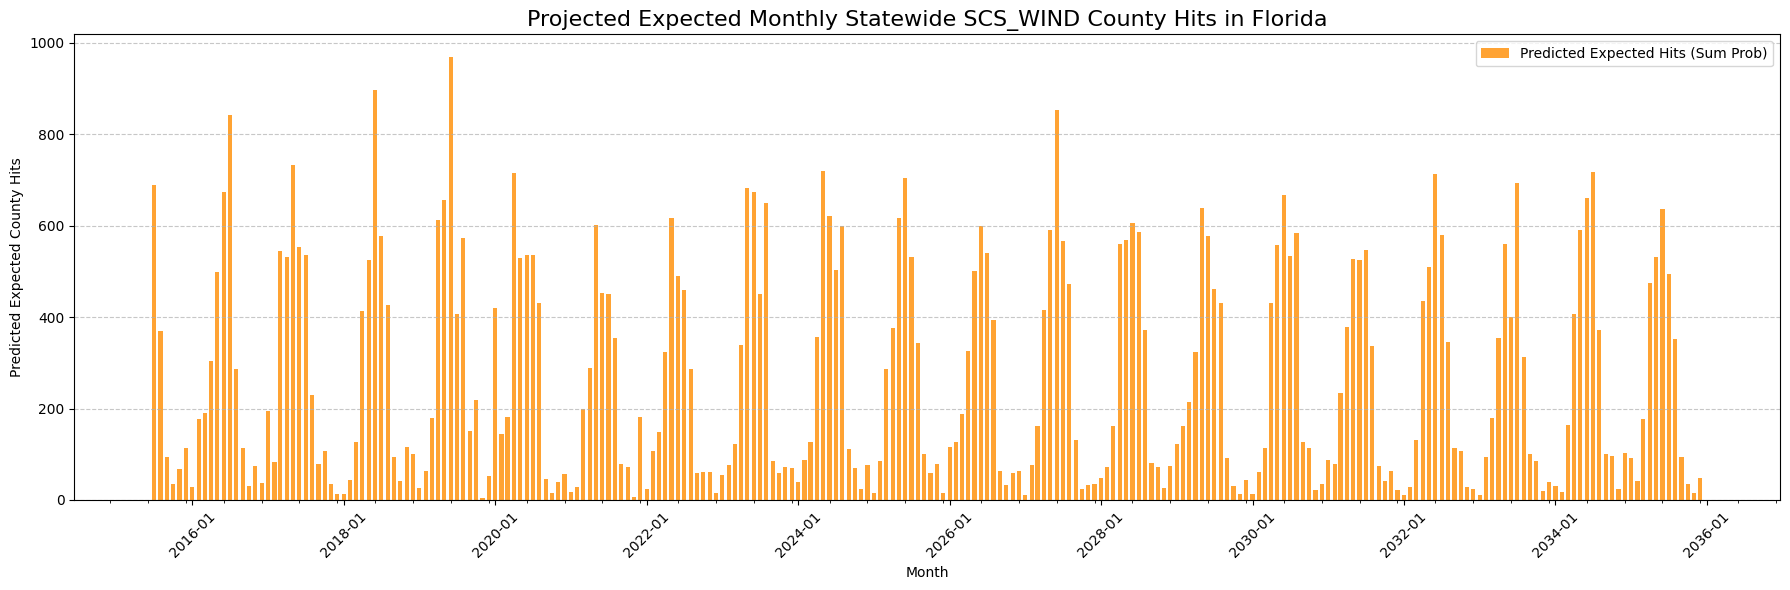

In [18]:
# --- Cell 18: Bar Chart of Predicted Expected Hits Over Time ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np # Ensure numpy is imported

logger.info("Generating bar chart of PREDICTED statewide monthly expected hits...")

try:
    # --- Check required DataFrames from previous cells ---
    # df_hist_monthly_expected was created in the revised Cell #10 (or a potential Cell #10.5)
    if 'df_hist_monthly_expected' not in locals() or df_hist_monthly_expected.empty:
        raise NameError("Historical predictions (df_hist_monthly_expected) missing. Ensure Cell 10 ran.")
    # df_future_monthly_expected was created in Cell #17
    if 'df_future_monthly_expected' not in locals() or df_future_monthly_expected.empty:
        raise NameError("Future predictions (df_future_monthly_expected) missing. Ensure Cell 17 ran.")

    # --- Combine Historical and Future PREDICTIONS ---
    logger.debug("Combining historical and future predicted expected hits...")
    # Ensure 'time' columns are datetime
    df_hist_monthly_expected['time'] = pd.to_datetime(df_hist_monthly_expected['time'])
    df_future_monthly_expected['time'] = pd.to_datetime(df_future_monthly_expected['time'])

    # Merge historical and future predictions using outer join
    df_pred_full_timeline = pd.merge(
        df_hist_monthly_expected[['time', 'hist_pred_expected_hits']],
        df_future_monthly_expected[['time', 'future_expected_hits']],
        on='time',
        how='outer'
    )
    # Combine the two prediction columns into one, filling NaNs appropriately
    # Fill future NaNs with historical values, then fill remaining (historical) NaNs with future values
    df_pred_full_timeline['predicted_expected_hits'] = df_pred_full_timeline['future_expected_hits'].fillna(
        df_pred_full_timeline['hist_pred_expected_hits']
    )
    # Drop the intermediate columns and any rows where prediction is still NaN (shouldn't happen with outer merge)
    df_pred_full_timeline = df_pred_full_timeline[['time', 'predicted_expected_hits']].dropna().sort_values('time')

    logger.info(f"Combined predicted expected hits data prepared. Shape: {df_pred_full_timeline.shape}")
    if df_pred_full_timeline.empty:
        raise ValueError("No predicted expected hits data available to plot.")

    # --- Create the Bar Chart ---
    logger.info("Creating bar chart of predicted expected hits...")
    fig, ax = plt.subplots(figsize=(18, 6))

    bar_width = 20 # Approximate width in days for monthly bars

    # Plot the combined predicted expected hits
    ax.bar(df_pred_full_timeline['time'],
           df_pred_full_timeline['predicted_expected_hits'],
           width=bar_width,
           label='Predicted Expected Hits (Sum Prob)',
           align='center',
           color='darkorange',
           alpha=0.8)

    # Customize plot
    ax.set_title(f'Projected Expected Monthly Statewide {TARGET_EVENT_TYPE.upper()} County Hits in Florida', fontsize=16)
    ax.set_xlabel("Month")
    ax.set_ylabel("Predicted Expected County Hits")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Format x-axis for dates
    ax.xaxis.set_major_locator(mdates.YearLocator(2)) # Major ticks every 2 years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=6)) # Minor ticks every 6 months
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the figure
    plot_filename = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_statewide_EXPECTED_hits_timeline.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    logger.info(f"Predicted expected hits bar chart saved to {plot_filename}")

    plt.show()

except NameError as ne:
     logger.error(f"Required variable not found for plot: {ne}. Ensure previous cells ran.")
except ValueError as ve:
     logger.error(f"ValueError during plot generation: {ve}")
except Exception as e:
    logger.exception(f"Failed during predicted expected hits chart generation: {e}")

[2025-04-11 10:56:39] [INFO] ModelTrainingLoggerSCS_TargetStates - Generating yearly statewide predicted expected hits chart and CAGR...
[2025-04-11 10:56:39] [INFO] ModelTrainingLoggerSCS_TargetStates - Preparing yearly aggregate data for plotting...
[2025-04-11 10:56:39] [INFO] ModelTrainingLoggerSCS_TargetStates - Yearly aggregate data prepared.


,year,actual_hits,predicted_expected_hits
7,2021,6040.0,NaN
8,2022,7626.0,NaN
9,2023,12182.0,NaN
10,2024,9006.0,NaN
11,2025,NaN,3214.135499
12,2026,NaN,3009.320187
13,2027,NaN,3372.298588
14,2028,NaN,3227.537729
15,2029,NaN,3113.741395
16,2030,NaN,3261.472833


[2025-04-11 10:56:39] [INFO] ModelTrainingLoggerSCS_TargetStates - Calculating projected CAGR for 2025-2034...
[2025-04-11 10:56:39] [INFO] ModelTrainingLoggerSCS_TargetStates - Projected Statewide Expected Hits CAGR (2025-2034): 0.23%
[2025-04-11 10:56:39] [INFO] ModelTrainingLoggerSCS_TargetStates - Creating yearly bar chart...
[2025-04-11 10:56:39] [INFO] ModelTrainingLoggerSCS_TargetStates - Creating yearly bar chart...



Projected Statewide Expected Hits CAGR (2025-2034): 0.23%


[2025-04-11 10:56:40] [INFO] ModelTrainingLoggerSCS_TargetStates - Yearly bar chart saved to ../output/models\scs_wind_target_statewide_YEARLY_comparison_hist_future.png


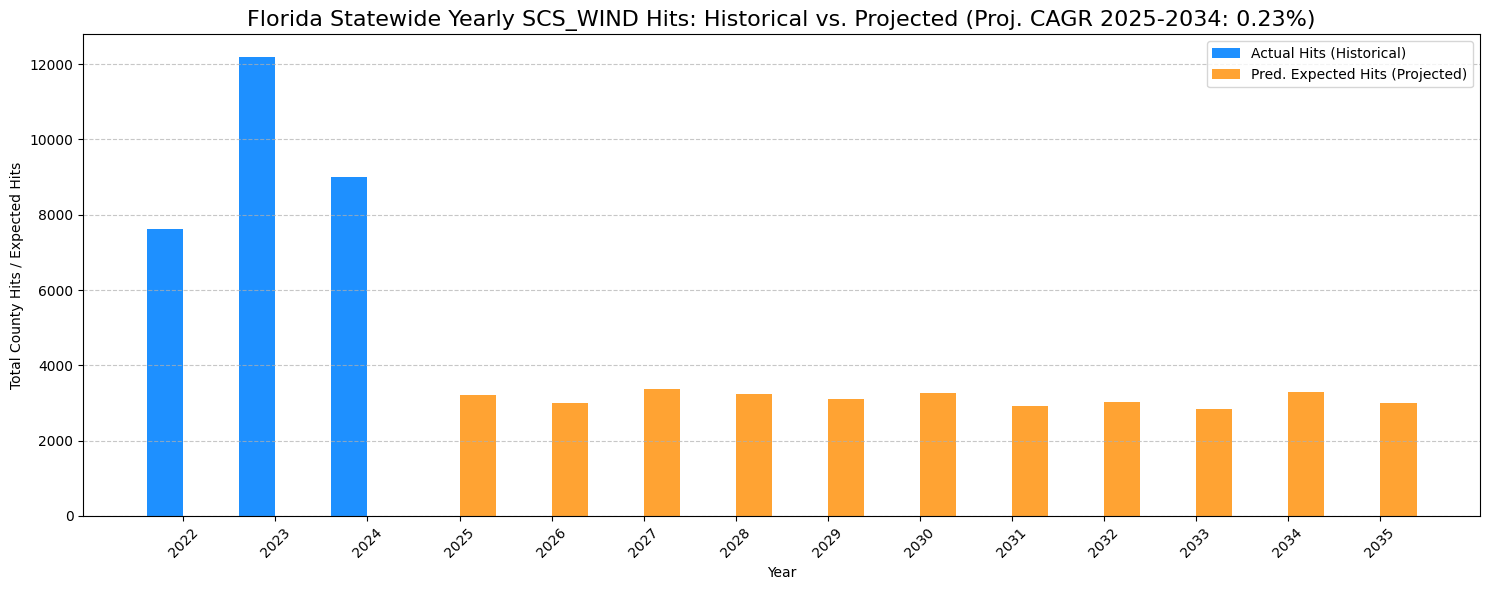

In [19]:
# --- Cell 19: Yearly Projected Statewide Hits Bar Chart & CAGR ---
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For formatting percentages
import pandas as pd
import numpy as np # Ensure numpy is imported

logger.info("Generating yearly statewide predicted expected hits chart and CAGR...")

# --- Helper Function for CAGR (copy from Cell 14 if needed) ---
def calculate_cagr(start_value, end_value, num_years):
    """Calculates Compound Annual Growth Rate, handling zero start."""
    start_value = pd.to_numeric(start_value, errors='coerce')
    end_value = pd.to_numeric(end_value, errors='coerce')
    if pd.isna(start_value) or pd.isna(end_value) or num_years <= 0: return np.nan
    if start_value <= 1e-6: # Use small threshold instead of == 0 for float
        if end_value > 1e-6: return np.inf
        else: return 0.0
    # Use np.power for potentially negative bases if needed, but counts should be non-negative
    # Adding small epsilon inside power for robustness if start/end can be zero
    power_base = (end_value + 1e-9) / (start_value + 1e-9)
    # Handle potential complex numbers if power_base becomes negative (shouldn't for counts)
    if power_base < 0: return np.nan
    return (power_base**(1 / num_years)) - 1


try:
    # --- Validate required input DataFrames ---
    if 'df_future_annual_expected_hits' not in locals() or df_future_annual_expected_hits.empty:
        raise ValueError("Future yearly expected hits data (df_future_annual_expected_hits) missing. Cell 12 needed.")
    # Also need historical yearly actuals for context plot
    if 'df_hist_actual_hits_full' not in locals() or df_hist_actual_hits_full.empty:
         logger.warning("Historical hits data (df_hist_actual_hits_full) missing. Plot will only show future.")
         df_hist_yearly_actual = pd.DataFrame({'year': [], 'actual_hits': []}) # Empty placeholder
    else:
         # Ensure needed columns exist from Cell 13's output (using the renamed variable)
         if 'actual_hits' not in df_hist_actual_hits_full.columns: # Check name used in Cell 13/14
             if 'actual_hits_yearly' in df_hist_actual_hits_full.columns:
                 df_hist_actual_hits_full = df_hist_actual_hits_full.rename(columns={'actual_hits_yearly': 'actual_hits'})
             else: raise ValueError("'actual_hits' or 'actual_hits_yearly' column missing in historical data.")
         df_hist_yearly_actual = df_hist_actual_hits_full.groupby('year')['actual_hits'].sum().reset_index()


    # --- 1. Prepare Yearly Aggregate Data ---
    logger.info("Preparing yearly aggregate data for plotting...")
    # Future Expected Yearly Counts (Sum across counties)
    df_future_yearly_sum = df_future_annual_expected_hits.groupby('year')['total_expected_hits_per_year'].sum().reset_index()
    df_future_yearly_sum.rename(columns={'total_expected_hits_per_year': 'predicted_expected_hits'}, inplace=True)

    # Combine Historical Actual and Future Predicted Yearly Data
    df_yearly_agg = pd.merge(df_hist_yearly_actual, df_future_yearly_sum, on='year', how='outer')
    df_yearly_agg.sort_values('year', inplace=True)
    logger.info("Yearly aggregate data prepared.")
    display(df_yearly_agg.tail(15)) # Show recent history + future

    # --- 2. Calculate Future CAGR (2025-2034) ---
    logger.info("Calculating projected CAGR for 2025-2034...")
    cagr_start_year = 2025
    cagr_end_year = 2034 # Note: Calculation uses 10 periods (2025 to 2034 inclusive)
    num_cagr_years = cagr_end_year - cagr_start_year

    start_val = df_yearly_agg[df_yearly_agg['year'] == cagr_start_year]['predicted_expected_hits'].iloc[0] if not df_yearly_agg[df_yearly_agg['year'] == cagr_start_year].empty else np.nan
    end_val = df_yearly_agg[df_yearly_agg['year'] == cagr_end_year]['predicted_expected_hits'].iloc[0] if not df_yearly_agg[df_yearly_agg['year'] == cagr_end_year].empty else np.nan

    projected_cagr = calculate_cagr(start_val, end_val, num_cagr_years) if num_cagr_years > 0 else np.nan

    logger.info(f"Projected Statewide Expected Hits CAGR ({cagr_start_year}-{cagr_end_year}): {projected_cagr:.2%}" if not pd.isna(projected_cagr) else "N/A")
    print(f"\nProjected Statewide Expected Hits CAGR ({cagr_start_year}-{cagr_end_year}): {projected_cagr:.2%}" if not pd.isna(projected_cagr) else "N/A")


    # --- 3. Create Yearly Bar Chart ---
    logger.info("Creating yearly bar chart...")
    # --- 4. Create Yearly Bar Chart ---
    logger.info("Creating yearly bar chart...")
    fig_y, ax_y = plt.subplots(figsize=(15, 6))

    bar_width = 0.4
    # Years to plot - e.g., recent history + projection period
    plot_start_year = 2022
    plot_end_year = 2035 # Ensure this aligns with MAX_PROCESSING_YEAR if needed
    plot_df = df_yearly_agg[(df_yearly_agg['year'] >= plot_start_year) & (df_yearly_agg['year'] <= plot_end_year)].copy()

    # Plot historical actuals where available
    hist_mask_y = plot_df['actual_hits'].notna()
    if hist_mask_y.any():
        ax_y.bar(plot_df.loc[hist_mask_y, 'year'] - bar_width/2, plot_df.loc[hist_mask_y, 'actual_hits'],
                 width=bar_width, label='Actual Hits (Historical)', align='center', color='dodgerblue')

    # Plot future expected where available
    future_mask_y = plot_df['predicted_expected_hits'].notna() # Use correct column name here too
    if future_mask_y.any():
        # *** CORRECTED COLUMN NAME IN NEXT LINE ***
        ax_y.bar(plot_df.loc[future_mask_y, 'year'] + bar_width/2, plot_df.loc[future_mask_y, 'predicted_expected_hits'],
                 width=bar_width, label='Pred. Expected Hits (Projected)', align='center', color='darkorange', alpha=0.8)
        # *** END CORRECTION ***

    # Customize plot
    cagr_text = f" (Proj. CAGR {cagr_start_year}-{cagr_end_year}: {projected_cagr:.2%})" if not pd.isna(projected_cagr) else ""
    ax_y.set_title(f'Florida Statewide Yearly {TARGET_EVENT_TYPE.upper()} Hits: Historical vs. Projected{cagr_text}', fontsize=16)
    ax_y.set_xlabel("Year")
    ax_y.set_ylabel("Total County Hits / Expected Hits")
    ax_y.legend()
    ax_y.grid(axis='y', linestyle='--', alpha=0.7)
    # Ensure all years are shown, even if data is sparse for some
    plot_years = sorted(plot_df['year'].unique()) # Use years present in plot_df
    ax_y.set_xticks(plot_years)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the figure
    plot_filename = os.path.join(MODEL_OUTPUT_DIR, f"{TARGET_EVENT_TYPE}_target_statewide_YEARLY_comparison_hist_future.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    logger.info(f"Yearly bar chart saved to {plot_filename}")

    plt.show()


except ValueError as ve: logger.error(f"ValueError during chart gen: {ve}")
except NameError as ne: logger.error(f"Variable not found for charts: {ne}.")
except Exception as e: logger.exception(f"Failed chart generation: {e}")